### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked

n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)
        
        # init is very very important!!!
        # no init version -> HASH:ef56239
        init.xavier_normal_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        init.xavier_normal_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        init.xavier_normal_(self.conv3.weight)
        init.constant_(self.conv3.bias, 0)
        
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        init.constant_(self.bn3.weight, 1)
        init.constant_(self.bn3.bias, 0)
        
        init.normal_(self.fc.weight, 0, 0.01)
        init.constant_(self.fc.bias, 1) # not 0 but 1.
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimization
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn1.weight'], params['bn1.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn2.weight'], params['bn2.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn3.weight'], params['bn3.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

### Dataset

In [2]:
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### AugmentedDataset (for meta-train)

In [3]:
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### DataLoader

local_task_train_data
../data/omniglot_mini/images_background/Latin/


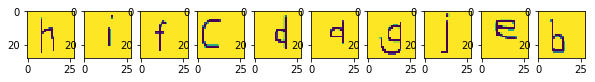

y_true: tensor([7, 8, 5, 2, 3, 0, 6, 9, 4, 1])

local_task_test_data


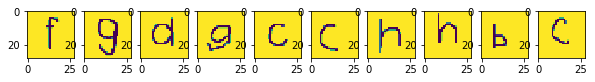

y_true: tensor([5, 6, 0, 6, 2, 2, 7, 7, 1, 2])


In [4]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print("local_task_train_data")
print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    
print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

### AugmentDataLoader

local_task_train_data


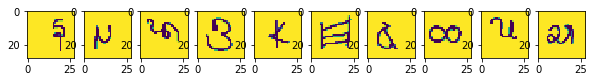

y_true: tensor([4, 1, 3, 7, 2, 0, 9, 8, 6, 5])

local_task_test_data


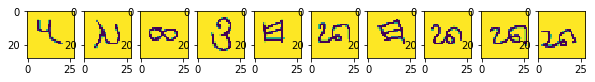

y_true: tensor([6, 1, 8, 7, 0, 3, 0, 3, 3, 3])


In [5]:
train_indices = np.random.randint(20, size=(n_class, n_shot))

path_to_chars = [
    '../data/omniglot_mini/images_background/Early_Aramaic/character08',
    '../data/omniglot_mini/images_background/N_Ko/character05',
    '../data/omniglot_mini/images_background/Early_Aramaic/character01',
    '../data/omniglot_mini/images_background/Balinese/character04',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character21',
    '../data/omniglot_mini/images_background/Balinese/character03',
    '../data/omniglot_mini/images_background/Gujarati/character35',
    '../data/omniglot_mini/images_background/Bengali/character10',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character18',
    '../data/omniglot_mini/images_background/Armenian/character17'
]

print("local_task_train_data")
local_task_train_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=True,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=False,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

### (fitting, task=Latin, n_class=10, n_shot=1)

100%|██████████| 10/10 [00:00<00:00, 50.24it/s, epoch=10, train_loss=0.174, train_acc=1, test_loss=2.18, test_acc=0.253]


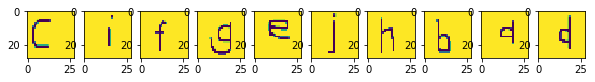

y_pred: tensor([2, 8, 5, 6, 4, 9, 7, 1, 0, 3])
y_true: tensor([2, 8, 5, 6, 4, 9, 7, 1, 0, 3])


In [6]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### (fitting, task=MNIST, n_class=10, n_shot=1)

100%|██████████| 1/1 [00:15<00:00, 15.25s/it, epoch=1, train_loss=0.0155, train_acc=0.958, test_loss=0.0623, test_acc=0.981]


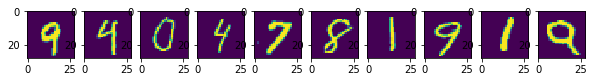

y_pred: tensor([9, 4, 0, 4, 7, 8, 1, 9, 1, 9])
y_true: tensor([9, 4, 0, 4, 7, 8, 1, 9, 1, 9])


In [7]:
local_task_train_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(1)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### Taskset and TaskLoader classes

In [8]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

### Taskset

In [9]:
class OmniglotOriginTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_langs))
        tasks = [os.path.join(path_to_langs, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_index=[np.random.randint(20)] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### AugmentedTaskset (for meta-train)

In [10]:
class OmniglotAugmentedTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            
        chars = []
        
        for path_to_lang in os.listdir(path_to_langs):
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char)) 
        
        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last
        
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### TaskLoader

30
../data/omniglot_mini/images_background/Sanskrit
train


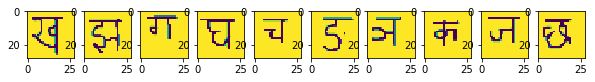

tensor([1, 8, 2, 3, 5, 4, 9, 0, 7, 6])
test


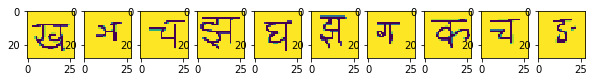

tensor([1, 9, 5, 8, 3, 8, 2, 0, 5, 4])
../data/omniglot_mini/images_background/Syriac_(Estrangelo)
train


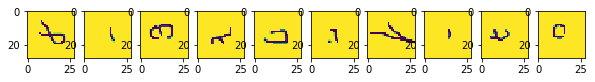

tensor([8, 6, 4, 0, 1, 3, 2, 9, 7, 5])
test


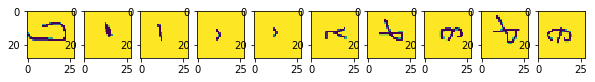

tensor([1, 6, 6, 9, 9, 0, 8, 4, 8, 4])


In [11]:
meta_train_task_loader = TaskLoader(
    OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_train_data_loader = meta_train_task["test"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

### AugmentTaskLoader

96
['../data/omniglot_mini/images_background/Japanese_(hiragana)/character41', '../data/omniglot_mini/images_background/Sanskrit/character11', '../data/omniglot_mini/images_background/Inuktitut_(Canadian_Aboriginal_Syllabics)/character07', '../data/omniglot_mini/images_background/Sanskrit/character14', '../data/omniglot_mini/images_background/Gujarati/character07', '../data/omniglot_mini/images_background/Cyrillic/character11', '../data/omniglot_mini/images_background/Korean/character11', '../data/omniglot_mini/images_background/Bengali/character09', '../data/omniglot_mini/images_background/Korean/character21', '../data/omniglot_mini/images_background/Syriac_(Estrangelo)/character17']
train


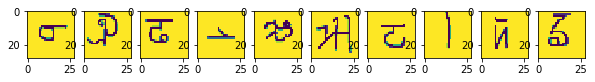

tensor([2, 7, 3, 9, 4, 6, 1, 8, 5, 0])
test


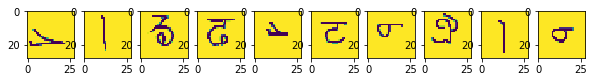

tensor([9, 8, 0, 3, 9, 1, 2, 7, 8, 2])
['../data/omniglot_mini/images_background/Japanese_(katakana)/character32', '../data/omniglot_mini/images_background/N_Ko/character10', '../data/omniglot_mini/images_background/Braille/character09', '../data/omniglot_mini/images_background/Japanese_(katakana)/character39', '../data/omniglot_mini/images_background/Arcadian/character23', '../data/omniglot_mini/images_background/Alphabet_of_the_Magi/character19', '../data/omniglot_mini/images_background/Malay_(Jawi_-_Arabic)/character40', '../data/omniglot_mini/images_background/Early_Aramaic/character05', '../data/omniglot_mini/images_background/Grantha/character18', '../data/omniglot_mini/images_background/Sanskrit/character17']
train


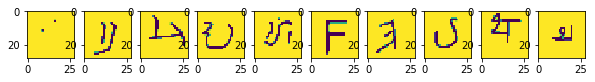

tensor([2, 3, 0, 5, 4, 1, 7, 6, 9, 8])
test


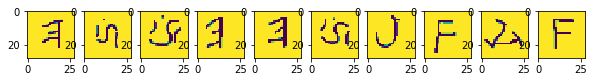

tensor([7, 4, 4, 7, 7, 4, 6, 1, 0, 1])


In [12]:
meta_train_task_loader = TaskLoader(
    OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

---

# MAML

In [13]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)
    
    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):
                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        meta_grads = []
        
        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:
                
                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                faster_net.forward = NotImplementedError # goodbye!
                self.copy_params(self.master_net, faster_net)

                faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]

                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------

                first_train_for_this_task = True

                for epoch in range(n_local_update):
                    
                    _train_loss = 0 # For tqdm.
                    _train_acc = 0 # For tqdm.
                    
                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            # manual predict
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                            
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            first_train_for_this_task = False

                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                                                        
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)
        
                        # manual optimize!!!
                        faster_params = OrderedDict(
                            (name, param - self.lr*grad)
                            for ((name, param), grad) in zip(faster_params.items(), grads)
                        )
                    
                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)
                    
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                
                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------
                
                _test_loss = 0 # For logging.
                _test_acc = 0 # For logging.
                
                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss計算するとこまではfaster_net

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()
                    
                    _test_loss += loss.item()
                    _test_acc += acc.item()
                
                _test_loss /= len(local_task_test_data_loader.dataset)
                _test_acc /= len(local_task_test_data_loader.dataset)  
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        # ----------------------------------------------------------------
        # end all tasks
        # ----------------------------------------------------------------
        
        # ----------------------------------------------------------------
        # meta update
        # ----------------------------------------------------------------
        
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        # using data,target from somewhere
        dumy_output = self.master_net(data)
        dumy_loss = F.nll_loss(dumy_output, target)
        
        # after dumy_loss.backward, rewrite grads
        self.master_opt.zero_grad()
        dumy_loss.backward(retain_graph=True)

        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))

        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        dumy_loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        return np.mean(test_loss), np.mean(test_acc)

In [14]:
meta_learner = MetaLearner()

# see normal few-shot learning
for _ in range(1):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))

for epoch in range(1000):
    
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    
    model_path = "../model/model-epoch_{:05}-train_loss_{:0.3f}-train_acc_{:0.3f}-test_loss_{:0.3f}-test_acc_{:0.3f}.pt".format(
        epoch, train_loss, train_acc, test_loss, test_acc)
    
    meta_learner.save(model_path)
    meta_learner.load(model_path)

Meta Test : 100%|█| 20/20 [00:01<00:00, 16.62it/s, epoch=5, train_loss=0.064, train_acc=1.000]


# 0  (meta-test-task) test_loss: 1.969074, test_acc: 0.352632


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.88it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 1 (meta-train-task) test_loss: 0.195474, test_acc: 0.490077
# 1  (meta-test-task) test_loss: 1.938746, test_acc: 0.353684


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.77it/s, epoch=5, train_loss=0.063, train_acc=1.000]


# 2 (meta-train-task) test_loss: 0.187710, test_acc: 0.528838
# 2  (meta-test-task) test_loss: 1.856654, test_acc: 0.404211


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.72it/s, epoch=5, train_loss=0.067, train_acc=1.000]


# 3 (meta-train-task) test_loss: 0.183141, test_acc: 0.533662
# 3  (meta-test-task) test_loss: 1.825682, test_acc: 0.425000


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.45it/s, epoch=5, train_loss=0.070, train_acc=1.000]


# 4 (meta-train-task) test_loss: 0.179364, test_acc: 0.540241
# 4  (meta-test-task) test_loss: 1.850635, test_acc: 0.407895


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.69it/s, epoch=5, train_loss=0.062, train_acc=1.000]


# 5 (meta-train-task) test_loss: 0.177618, test_acc: 0.535855
# 5  (meta-test-task) test_loss: 1.819764, test_acc: 0.418684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.13it/s, epoch=5, train_loss=0.083, train_acc=1.000]


# 6 (meta-train-task) test_loss: 0.175584, test_acc: 0.548355
# 6  (meta-test-task) test_loss: 1.776699, test_acc: 0.446316


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.45it/s, epoch=5, train_loss=0.070, train_acc=1.000]


# 7 (meta-train-task) test_loss: 0.173254, test_acc: 0.552303
# 7  (meta-test-task) test_loss: 1.807230, test_acc: 0.421316


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.85it/s, epoch=5, train_loss=0.070, train_acc=1.000]


# 8 (meta-train-task) test_loss: 0.172150, test_acc: 0.557730
# 8  (meta-test-task) test_loss: 1.746390, test_acc: 0.454211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.26it/s, epoch=5, train_loss=0.074, train_acc=1.000]


# 9 (meta-train-task) test_loss: 0.169641, test_acc: 0.568860
# 9  (meta-test-task) test_loss: 1.712075, test_acc: 0.476842


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.75it/s, epoch=5, train_loss=0.060, train_acc=1.000]


# 10 (meta-train-task) test_loss: 0.167539, test_acc: 0.589035
# 10  (meta-test-task) test_loss: 1.711890, test_acc: 0.470789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.66it/s, epoch=5, train_loss=0.090, train_acc=1.000]


# 11 (meta-train-task) test_loss: 0.166072, test_acc: 0.601754
# 11  (meta-test-task) test_loss: 1.729726, test_acc: 0.449474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.062, train_acc=1.000]


# 12 (meta-train-task) test_loss: 0.163070, test_acc: 0.612007
# 12  (meta-test-task) test_loss: 1.700835, test_acc: 0.463421


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.78it/s, epoch=5, train_loss=0.062, train_acc=1.000]


# 13 (meta-train-task) test_loss: 0.164082, test_acc: 0.605976
# 13  (meta-test-task) test_loss: 1.641442, test_acc: 0.501842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.080, train_acc=1.000]


# 14 (meta-train-task) test_loss: 0.160593, test_acc: 0.629770
# 14  (meta-test-task) test_loss: 1.634204, test_acc: 0.477895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.046, train_acc=1.000]


# 15 (meta-train-task) test_loss: 0.159765, test_acc: 0.634814
# 15  (meta-test-task) test_loss: 1.611116, test_acc: 0.501053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.05it/s, epoch=5, train_loss=0.082, train_acc=1.000]


# 16 (meta-train-task) test_loss: 0.157718, test_acc: 0.654441
# 16  (meta-test-task) test_loss: 1.641852, test_acc: 0.466053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.42it/s, epoch=5, train_loss=0.052, train_acc=1.000]


# 17 (meta-train-task) test_loss: 0.157232, test_acc: 0.646327
# 17  (meta-test-task) test_loss: 1.560348, test_acc: 0.524737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.86it/s, epoch=5, train_loss=0.060, train_acc=1.000]


# 18 (meta-train-task) test_loss: 0.156118, test_acc: 0.656908
# 18  (meta-test-task) test_loss: 1.577494, test_acc: 0.528684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.070, train_acc=1.000]


# 19 (meta-train-task) test_loss: 0.153177, test_acc: 0.673191
# 19  (meta-test-task) test_loss: 1.585463, test_acc: 0.517368


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.53it/s, epoch=5, train_loss=0.056, train_acc=1.000]


# 20 (meta-train-task) test_loss: 0.154011, test_acc: 0.664583
# 20  (meta-test-task) test_loss: 1.563534, test_acc: 0.518947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.70it/s, epoch=5, train_loss=0.052, train_acc=1.000]


# 21 (meta-train-task) test_loss: 0.151039, test_acc: 0.681908
# 21  (meta-test-task) test_loss: 1.564365, test_acc: 0.507895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.33it/s, epoch=5, train_loss=0.053, train_acc=1.000]


# 22 (meta-train-task) test_loss: 0.152327, test_acc: 0.658991
# 22  (meta-test-task) test_loss: 1.554464, test_acc: 0.505789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.14it/s, epoch=5, train_loss=0.046, train_acc=1.000]


# 23 (meta-train-task) test_loss: 0.150091, test_acc: 0.679550
# 23  (meta-test-task) test_loss: 1.562231, test_acc: 0.509211


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.84it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 24 (meta-train-task) test_loss: 0.150383, test_acc: 0.680702
# 24  (meta-test-task) test_loss: 1.586631, test_acc: 0.495526


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.16it/s, epoch=5, train_loss=0.057, train_acc=1.000]


# 25 (meta-train-task) test_loss: 0.147759, test_acc: 0.693695
# 25  (meta-test-task) test_loss: 1.515633, test_acc: 0.551579


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.12it/s, epoch=5, train_loss=0.055, train_acc=1.000]


# 26 (meta-train-task) test_loss: 0.147039, test_acc: 0.691886
# 26  (meta-test-task) test_loss: 1.515763, test_acc: 0.535789


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.01it/s, epoch=5, train_loss=0.055, train_acc=1.000]


# 27 (meta-train-task) test_loss: 0.145847, test_acc: 0.699561
# 27  (meta-test-task) test_loss: 1.528360, test_acc: 0.512368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.19it/s, epoch=5, train_loss=0.054, train_acc=1.000]


# 28 (meta-train-task) test_loss: 0.146325, test_acc: 0.696107
# 28  (meta-test-task) test_loss: 1.514128, test_acc: 0.531316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.16it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 29 (meta-train-task) test_loss: 0.143800, test_acc: 0.694901
# 29  (meta-test-task) test_loss: 1.467251, test_acc: 0.554474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.95it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 30 (meta-train-task) test_loss: 0.142544, test_acc: 0.710910
# 30  (meta-test-task) test_loss: 1.540924, test_acc: 0.524474


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.07it/s, epoch=5, train_loss=0.055, train_acc=1.000]


# 31 (meta-train-task) test_loss: 0.142614, test_acc: 0.703509
# 31  (meta-test-task) test_loss: 1.493057, test_acc: 0.522105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.056, train_acc=1.000]


# 32 (meta-train-task) test_loss: 0.141582, test_acc: 0.715680
# 32  (meta-test-task) test_loss: 1.489887, test_acc: 0.542895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.48it/s, epoch=5, train_loss=0.064, train_acc=1.000]


# 33 (meta-train-task) test_loss: 0.141832, test_acc: 0.706414
# 33  (meta-test-task) test_loss: 1.490150, test_acc: 0.529474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 34 (meta-train-task) test_loss: 0.140148, test_acc: 0.717489
# 34  (meta-test-task) test_loss: 1.472670, test_acc: 0.554211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.042, train_acc=1.000]


# 35 (meta-train-task) test_loss: 0.139035, test_acc: 0.716228
# 35  (meta-test-task) test_loss: 1.501597, test_acc: 0.540000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.52it/s, epoch=5, train_loss=0.054, train_acc=1.000]


# 36 (meta-train-task) test_loss: 0.138659, test_acc: 0.720285
# 36  (meta-test-task) test_loss: 1.481911, test_acc: 0.535526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.047, train_acc=1.000]


# 37 (meta-train-task) test_loss: 0.139166, test_acc: 0.718750
# 37  (meta-test-task) test_loss: 1.407286, test_acc: 0.576842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.27it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 38 (meta-train-task) test_loss: 0.137885, test_acc: 0.721162
# 38  (meta-test-task) test_loss: 1.455598, test_acc: 0.554474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.46it/s, epoch=5, train_loss=0.053, train_acc=1.000]


# 39 (meta-train-task) test_loss: 0.136559, test_acc: 0.734265
# 39  (meta-test-task) test_loss: 1.465397, test_acc: 0.555526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.92it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 40 (meta-train-task) test_loss: 0.136021, test_acc: 0.734978
# 40  (meta-test-task) test_loss: 1.396243, test_acc: 0.569737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.26it/s, epoch=5, train_loss=0.057, train_acc=1.000]


# 41 (meta-train-task) test_loss: 0.135221, test_acc: 0.730482
# 41  (meta-test-task) test_loss: 1.431882, test_acc: 0.557895


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.94it/s, epoch=5, train_loss=0.048, train_acc=1.000]


# 42 (meta-train-task) test_loss: 0.133094, test_acc: 0.750713
# 42  (meta-test-task) test_loss: 1.407218, test_acc: 0.593684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.99it/s, epoch=5, train_loss=0.046, train_acc=1.000]


# 43 (meta-train-task) test_loss: 0.133526, test_acc: 0.741447
# 43  (meta-test-task) test_loss: 1.388261, test_acc: 0.582368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.79it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 44 (meta-train-task) test_loss: 0.131668, test_acc: 0.745504
# 44  (meta-test-task) test_loss: 1.452865, test_acc: 0.543947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.89it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 45 (meta-train-task) test_loss: 0.132596, test_acc: 0.740186
# 45  (meta-test-task) test_loss: 1.413717, test_acc: 0.569211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.23it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 46 (meta-train-task) test_loss: 0.133658, test_acc: 0.736020
# 46  (meta-test-task) test_loss: 1.371785, test_acc: 0.591579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.08it/s, epoch=5, train_loss=0.052, train_acc=1.000]


# 47 (meta-train-task) test_loss: 0.130477, test_acc: 0.755263
# 47  (meta-test-task) test_loss: 1.441952, test_acc: 0.543947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.065, train_acc=1.000]


# 48 (meta-train-task) test_loss: 0.130284, test_acc: 0.759594
# 48  (meta-test-task) test_loss: 1.381060, test_acc: 0.573158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.66it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 49 (meta-train-task) test_loss: 0.128547, test_acc: 0.766612
# 49  (meta-test-task) test_loss: 1.389449, test_acc: 0.564474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.041, train_acc=1.000]


# 50 (meta-train-task) test_loss: 0.129452, test_acc: 0.751151
# 50  (meta-test-task) test_loss: 1.370992, test_acc: 0.572632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.053, train_acc=1.000]


# 51 (meta-train-task) test_loss: 0.127758, test_acc: 0.768421
# 51  (meta-test-task) test_loss: 1.384804, test_acc: 0.581579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 52 (meta-train-task) test_loss: 0.126069, test_acc: 0.772752
# 52  (meta-test-task) test_loss: 1.347729, test_acc: 0.595789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 53 (meta-train-task) test_loss: 0.127159, test_acc: 0.766173
# 53  (meta-test-task) test_loss: 1.409563, test_acc: 0.566316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.47it/s, epoch=5, train_loss=0.039, train_acc=1.000]


# 54 (meta-train-task) test_loss: 0.126762, test_acc: 0.772643
# 54  (meta-test-task) test_loss: 1.362005, test_acc: 0.580789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 55 (meta-train-task) test_loss: 0.126186, test_acc: 0.766557
# 55  (meta-test-task) test_loss: 1.401312, test_acc: 0.577368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.00it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 56 (meta-train-task) test_loss: 0.125051, test_acc: 0.776480
# 56  (meta-test-task) test_loss: 1.363880, test_acc: 0.567895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.90it/s, epoch=5, train_loss=0.047, train_acc=1.000]


# 57 (meta-train-task) test_loss: 0.124465, test_acc: 0.775000
# 57  (meta-test-task) test_loss: 1.308286, test_acc: 0.616842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.09it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 58 (meta-train-task) test_loss: 0.124297, test_acc: 0.770888
# 58  (meta-test-task) test_loss: 1.376553, test_acc: 0.573684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.64it/s, epoch=5, train_loss=0.060, train_acc=1.000]


# 59 (meta-train-task) test_loss: 0.121784, test_acc: 0.794189
# 59  (meta-test-task) test_loss: 1.319719, test_acc: 0.581316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.083, train_acc=1.000]


# 60 (meta-train-task) test_loss: 0.121908, test_acc: 0.778235
# 60  (meta-test-task) test_loss: 1.351316, test_acc: 0.581316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.89it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 61 (meta-train-task) test_loss: 0.121564, test_acc: 0.783553
# 61  (meta-test-task) test_loss: 1.307414, test_acc: 0.585526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.71it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 62 (meta-train-task) test_loss: 0.121719, test_acc: 0.775768
# 62  (meta-test-task) test_loss: 1.343967, test_acc: 0.585526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 63 (meta-train-task) test_loss: 0.122958, test_acc: 0.768914
# 63  (meta-test-task) test_loss: 1.360517, test_acc: 0.568947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.55it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 64 (meta-train-task) test_loss: 0.120764, test_acc: 0.782292
# 64  (meta-test-task) test_loss: 1.315286, test_acc: 0.589211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.01it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 65 (meta-train-task) test_loss: 0.120189, test_acc: 0.788432
# 65  (meta-test-task) test_loss: 1.299848, test_acc: 0.595789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.01it/s, epoch=5, train_loss=0.048, train_acc=1.000]


# 66 (meta-train-task) test_loss: 0.119214, test_acc: 0.791338
# 66  (meta-test-task) test_loss: 1.339434, test_acc: 0.582105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.052, train_acc=1.000]


# 67 (meta-train-task) test_loss: 0.119202, test_acc: 0.793092
# 67  (meta-test-task) test_loss: 1.305928, test_acc: 0.607632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.51it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 68 (meta-train-task) test_loss: 0.118194, test_acc: 0.797149
# 68  (meta-test-task) test_loss: 1.312450, test_acc: 0.584474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.039, train_acc=1.000]


# 69 (meta-train-task) test_loss: 0.118156, test_acc: 0.794353
# 69  (meta-test-task) test_loss: 1.311164, test_acc: 0.602368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.92it/s, epoch=5, train_loss=0.049, train_acc=1.000]


# 70 (meta-train-task) test_loss: 0.118828, test_acc: 0.790844
# 70  (meta-test-task) test_loss: 1.272127, test_acc: 0.618947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 71 (meta-train-task) test_loss: 0.118395, test_acc: 0.784375
# 71  (meta-test-task) test_loss: 1.262102, test_acc: 0.617368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.00it/s, epoch=5, train_loss=0.053, train_acc=1.000]


# 72 (meta-train-task) test_loss: 0.116407, test_acc: 0.802357
# 72  (meta-test-task) test_loss: 1.269323, test_acc: 0.607632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.64it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 73 (meta-train-task) test_loss: 0.116645, test_acc: 0.801919
# 73  (meta-test-task) test_loss: 1.306496, test_acc: 0.594737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 74 (meta-train-task) test_loss: 0.116052, test_acc: 0.804331
# 74  (meta-test-task) test_loss: 1.265587, test_acc: 0.618421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.59it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 75 (meta-train-task) test_loss: 0.115335, test_acc: 0.801206
# 75  (meta-test-task) test_loss: 1.243565, test_acc: 0.611316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 76 (meta-train-task) test_loss: 0.114375, test_acc: 0.804605
# 76  (meta-test-task) test_loss: 1.300270, test_acc: 0.606053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.13it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 77 (meta-train-task) test_loss: 0.115153, test_acc: 0.802632
# 77  (meta-test-task) test_loss: 1.272882, test_acc: 0.616053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.030, train_acc=1.000]


# 78 (meta-train-task) test_loss: 0.114956, test_acc: 0.801645
# 78  (meta-test-task) test_loss: 1.276146, test_acc: 0.606842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.91it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 79 (meta-train-task) test_loss: 0.114044, test_acc: 0.807072
# 79  (meta-test-task) test_loss: 1.253325, test_acc: 0.630789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.29it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 80 (meta-train-task) test_loss: 0.114257, test_acc: 0.797807
# 80  (meta-test-task) test_loss: 1.266086, test_acc: 0.617632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.20it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 81 (meta-train-task) test_loss: 0.114088, test_acc: 0.804715
# 81  (meta-test-task) test_loss: 1.228646, test_acc: 0.628947


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.23it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 82 (meta-train-task) test_loss: 0.113722, test_acc: 0.809101
# 82  (meta-test-task) test_loss: 1.266835, test_acc: 0.602368


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.08it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 83 (meta-train-task) test_loss: 0.112814, test_acc: 0.809814
# 83  (meta-test-task) test_loss: 1.254502, test_acc: 0.599737


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.59it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 84 (meta-train-task) test_loss: 0.112562, test_acc: 0.814035
# 84  (meta-test-task) test_loss: 1.223362, test_acc: 0.640263


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.29it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 85 (meta-train-task) test_loss: 0.111266, test_acc: 0.812719
# 85  (meta-test-task) test_loss: 1.225335, test_acc: 0.626842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.048, train_acc=1.000]


# 86 (meta-train-task) test_loss: 0.110844, test_acc: 0.817818
# 86  (meta-test-task) test_loss: 1.325791, test_acc: 0.575263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.25it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 87 (meta-train-task) test_loss: 0.110879, test_acc: 0.818092
# 87  (meta-test-task) test_loss: 1.250868, test_acc: 0.621842


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.71it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 88 (meta-train-task) test_loss: 0.110613, test_acc: 0.818366
# 88  (meta-test-task) test_loss: 1.242154, test_acc: 0.609737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.21it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 89 (meta-train-task) test_loss: 0.109956, test_acc: 0.814803
# 89  (meta-test-task) test_loss: 1.233459, test_acc: 0.613684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.46it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 90 (meta-train-task) test_loss: 0.111382, test_acc: 0.810691
# 90  (meta-test-task) test_loss: 1.167380, test_acc: 0.650263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.050, train_acc=1.000]


# 91 (meta-train-task) test_loss: 0.109861, test_acc: 0.823520
# 91  (meta-test-task) test_loss: 1.172322, test_acc: 0.647632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 92 (meta-train-task) test_loss: 0.108177, test_acc: 0.831140
# 92  (meta-test-task) test_loss: 1.220998, test_acc: 0.620000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.42it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 93 (meta-train-task) test_loss: 0.107731, test_acc: 0.828180
# 93  (meta-test-task) test_loss: 1.192809, test_acc: 0.641579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.66it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 94 (meta-train-task) test_loss: 0.107749, test_acc: 0.829825
# 94  (meta-test-task) test_loss: 1.223716, test_acc: 0.639211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.045, train_acc=1.000]


# 95 (meta-train-task) test_loss: 0.107782, test_acc: 0.823684
# 95  (meta-test-task) test_loss: 1.251533, test_acc: 0.613947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 96 (meta-train-task) test_loss: 0.107465, test_acc: 0.822533
# 96  (meta-test-task) test_loss: 1.272797, test_acc: 0.604474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.47it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 97 (meta-train-task) test_loss: 0.107033, test_acc: 0.825987
# 97  (meta-test-task) test_loss: 1.206970, test_acc: 0.638158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 98 (meta-train-task) test_loss: 0.106080, test_acc: 0.839529
# 98  (meta-test-task) test_loss: 1.179998, test_acc: 0.639211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.99it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 99 (meta-train-task) test_loss: 0.106841, test_acc: 0.831195
# 99  (meta-test-task) test_loss: 1.209703, test_acc: 0.625263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.87it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 100 (meta-train-task) test_loss: 0.106472, test_acc: 0.836239
# 100  (meta-test-task) test_loss: 1.183391, test_acc: 0.641053


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.70it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 101 (meta-train-task) test_loss: 0.105909, test_acc: 0.829550
# 101  (meta-test-task) test_loss: 1.157658, test_acc: 0.655263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.85it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 102 (meta-train-task) test_loss: 0.106677, test_acc: 0.828235
# 102  (meta-test-task) test_loss: 1.191901, test_acc: 0.627632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.96it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 103 (meta-train-task) test_loss: 0.106079, test_acc: 0.829167
# 103  (meta-test-task) test_loss: 1.226122, test_acc: 0.618684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.030, train_acc=1.000]


# 104 (meta-train-task) test_loss: 0.106487, test_acc: 0.825768
# 104  (meta-test-task) test_loss: 1.134183, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.82it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 105 (meta-train-task) test_loss: 0.103915, test_acc: 0.842873
# 105  (meta-test-task) test_loss: 1.184962, test_acc: 0.644474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.23it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 106 (meta-train-task) test_loss: 0.105390, test_acc: 0.827138
# 106  (meta-test-task) test_loss: 1.180202, test_acc: 0.638158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 107 (meta-train-task) test_loss: 0.103943, test_acc: 0.837500
# 107  (meta-test-task) test_loss: 1.247172, test_acc: 0.609474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 108 (meta-train-task) test_loss: 0.105073, test_acc: 0.827193
# 108  (meta-test-task) test_loss: 1.169193, test_acc: 0.642632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.69it/s, epoch=5, train_loss=0.049, train_acc=1.000]


# 109 (meta-train-task) test_loss: 0.103096, test_acc: 0.833991
# 109  (meta-test-task) test_loss: 1.171475, test_acc: 0.634211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.22it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 110 (meta-train-task) test_loss: 0.101467, test_acc: 0.846491
# 110  (meta-test-task) test_loss: 1.165724, test_acc: 0.637632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.10it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 111 (meta-train-task) test_loss: 0.104346, test_acc: 0.833004
# 111  (meta-test-task) test_loss: 1.177908, test_acc: 0.650789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.62it/s, epoch=5, train_loss=0.030, train_acc=1.000]


# 112 (meta-train-task) test_loss: 0.103037, test_acc: 0.838925
# 112  (meta-test-task) test_loss: 1.160397, test_acc: 0.644737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 113 (meta-train-task) test_loss: 0.101730, test_acc: 0.845285
# 113  (meta-test-task) test_loss: 1.153778, test_acc: 0.653421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.047, train_acc=1.000]


# 114 (meta-train-task) test_loss: 0.101892, test_acc: 0.844079
# 114  (meta-test-task) test_loss: 1.144600, test_acc: 0.662105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.030, train_acc=1.000]


# 115 (meta-train-task) test_loss: 0.101401, test_acc: 0.847423
# 115  (meta-test-task) test_loss: 1.150967, test_acc: 0.638947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.86it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 116 (meta-train-task) test_loss: 0.101937, test_acc: 0.838816
# 116  (meta-test-task) test_loss: 1.137784, test_acc: 0.664474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 117 (meta-train-task) test_loss: 0.100743, test_acc: 0.843586
# 117  (meta-test-task) test_loss: 1.220257, test_acc: 0.623158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.78it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 118 (meta-train-task) test_loss: 0.100632, test_acc: 0.850000
# 118  (meta-test-task) test_loss: 1.194491, test_acc: 0.623158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.65it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 119 (meta-train-task) test_loss: 0.099952, test_acc: 0.854770
# 119  (meta-test-task) test_loss: 1.166075, test_acc: 0.650263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.86it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 120 (meta-train-task) test_loss: 0.098937, test_acc: 0.855482
# 120  (meta-test-task) test_loss: 1.235997, test_acc: 0.618684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.20it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 121 (meta-train-task) test_loss: 0.100828, test_acc: 0.849397
# 121  (meta-test-task) test_loss: 1.090779, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.62it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 122 (meta-train-task) test_loss: 0.099933, test_acc: 0.851151
# 122  (meta-test-task) test_loss: 1.175170, test_acc: 0.644211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.81it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 123 (meta-train-task) test_loss: 0.098553, test_acc: 0.854770
# 123  (meta-test-task) test_loss: 1.135732, test_acc: 0.635526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 124 (meta-train-task) test_loss: 0.099014, test_acc: 0.850439
# 124  (meta-test-task) test_loss: 1.127597, test_acc: 0.660789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.06it/s, epoch=5, train_loss=0.030, train_acc=1.000]


# 125 (meta-train-task) test_loss: 0.099285, test_acc: 0.855208
# 125  (meta-test-task) test_loss: 1.166926, test_acc: 0.635000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.75it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 126 (meta-train-task) test_loss: 0.099594, test_acc: 0.842763
# 126  (meta-test-task) test_loss: 1.114875, test_acc: 0.659737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.92it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 127 (meta-train-task) test_loss: 0.099725, test_acc: 0.849616
# 127  (meta-test-task) test_loss: 1.178020, test_acc: 0.637368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 128 (meta-train-task) test_loss: 0.098757, test_acc: 0.851700
# 128  (meta-test-task) test_loss: 1.093591, test_acc: 0.663947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.95it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 129 (meta-train-task) test_loss: 0.099172, test_acc: 0.847917
# 129  (meta-test-task) test_loss: 1.110958, test_acc: 0.663158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 130 (meta-train-task) test_loss: 0.096921, test_acc: 0.859649
# 130  (meta-test-task) test_loss: 1.174527, test_acc: 0.640526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 131 (meta-train-task) test_loss: 0.097652, test_acc: 0.855482
# 131  (meta-test-task) test_loss: 1.154172, test_acc: 0.646316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.22it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 132 (meta-train-task) test_loss: 0.096737, test_acc: 0.860855
# 132  (meta-test-task) test_loss: 1.183511, test_acc: 0.631842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.10it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 133 (meta-train-task) test_loss: 0.096926, test_acc: 0.853180
# 133  (meta-test-task) test_loss: 1.118841, test_acc: 0.650789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.63it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 134 (meta-train-task) test_loss: 0.097629, test_acc: 0.854167
# 134  (meta-test-task) test_loss: 1.102878, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.08it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 135 (meta-train-task) test_loss: 0.095592, test_acc: 0.856853
# 135  (meta-test-task) test_loss: 1.132982, test_acc: 0.653421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.33it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 136 (meta-train-task) test_loss: 0.094998, test_acc: 0.872862
# 136  (meta-test-task) test_loss: 1.118397, test_acc: 0.660000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 137 (meta-train-task) test_loss: 0.095855, test_acc: 0.862719
# 137  (meta-test-task) test_loss: 1.156791, test_acc: 0.631053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.30it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 138 (meta-train-task) test_loss: 0.096257, test_acc: 0.856579
# 138  (meta-test-task) test_loss: 1.094064, test_acc: 0.673421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 139 (meta-train-task) test_loss: 0.096080, test_acc: 0.860143
# 139  (meta-test-task) test_loss: 1.121246, test_acc: 0.653684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.36it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 140 (meta-train-task) test_loss: 0.095018, test_acc: 0.867873
# 140  (meta-test-task) test_loss: 1.078896, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.41it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 141 (meta-train-task) test_loss: 0.094724, test_acc: 0.870559
# 141  (meta-test-task) test_loss: 1.135499, test_acc: 0.657105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.58it/s, epoch=5, train_loss=0.039, train_acc=1.000]


# 142 (meta-train-task) test_loss: 0.095852, test_acc: 0.863487
# 142  (meta-test-task) test_loss: 1.080798, test_acc: 0.676053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.17it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 143 (meta-train-task) test_loss: 0.094151, test_acc: 0.865461
# 143  (meta-test-task) test_loss: 1.143802, test_acc: 0.637368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.22it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 144 (meta-train-task) test_loss: 0.095660, test_acc: 0.861568
# 144  (meta-test-task) test_loss: 1.164423, test_acc: 0.638421


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.14it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 145 (meta-train-task) test_loss: 0.095315, test_acc: 0.851809
# 145  (meta-test-task) test_loss: 1.070279, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.09it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 146 (meta-train-task) test_loss: 0.096523, test_acc: 0.855702
# 146  (meta-test-task) test_loss: 1.054081, test_acc: 0.685789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.30it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 147 (meta-train-task) test_loss: 0.094187, test_acc: 0.862116
# 147  (meta-test-task) test_loss: 1.095059, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.05it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 148 (meta-train-task) test_loss: 0.092532, test_acc: 0.866228
# 148  (meta-test-task) test_loss: 1.095017, test_acc: 0.660000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.20it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 149 (meta-train-task) test_loss: 0.093576, test_acc: 0.862774
# 149  (meta-test-task) test_loss: 1.101392, test_acc: 0.667368


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.70it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 150 (meta-train-task) test_loss: 0.093466, test_acc: 0.865735
# 150  (meta-test-task) test_loss: 1.136340, test_acc: 0.646842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.55it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 151 (meta-train-task) test_loss: 0.093354, test_acc: 0.863925
# 151  (meta-test-task) test_loss: 1.157701, test_acc: 0.647368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 152 (meta-train-task) test_loss: 0.091460, test_acc: 0.877522
# 152  (meta-test-task) test_loss: 1.175695, test_acc: 0.624474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.06it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 153 (meta-train-task) test_loss: 0.092275, test_acc: 0.869189
# 153  (meta-test-task) test_loss: 1.094751, test_acc: 0.649211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 154 (meta-train-task) test_loss: 0.093487, test_acc: 0.858991
# 154  (meta-test-task) test_loss: 1.141472, test_acc: 0.649737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.25it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 155 (meta-train-task) test_loss: 0.092225, test_acc: 0.863268
# 155  (meta-test-task) test_loss: 1.068285, test_acc: 0.665263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.93it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 156 (meta-train-task) test_loss: 0.091370, test_acc: 0.873958
# 156  (meta-test-task) test_loss: 1.084081, test_acc: 0.656316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 157 (meta-train-task) test_loss: 0.090980, test_acc: 0.870888
# 157  (meta-test-task) test_loss: 1.055185, test_acc: 0.686842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 158 (meta-train-task) test_loss: 0.090738, test_acc: 0.875384
# 158  (meta-test-task) test_loss: 1.073788, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.52it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 159 (meta-train-task) test_loss: 0.092765, test_acc: 0.864583
# 159  (meta-test-task) test_loss: 1.209657, test_acc: 0.619737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 160 (meta-train-task) test_loss: 0.091144, test_acc: 0.871436
# 160  (meta-test-task) test_loss: 1.122934, test_acc: 0.653158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.55it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 161 (meta-train-task) test_loss: 0.091854, test_acc: 0.862390
# 161  (meta-test-task) test_loss: 1.130203, test_acc: 0.655789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.62it/s, epoch=5, train_loss=0.046, train_acc=1.000]


# 162 (meta-train-task) test_loss: 0.090360, test_acc: 0.883059
# 162  (meta-test-task) test_loss: 1.110285, test_acc: 0.656053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.87it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 163 (meta-train-task) test_loss: 0.089940, test_acc: 0.872643
# 163  (meta-test-task) test_loss: 1.135688, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 164 (meta-train-task) test_loss: 0.090565, test_acc: 0.873081
# 164  (meta-test-task) test_loss: 1.090119, test_acc: 0.657105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 165 (meta-train-task) test_loss: 0.089550, test_acc: 0.875932
# 165  (meta-test-task) test_loss: 1.092030, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 166 (meta-train-task) test_loss: 0.090288, test_acc: 0.877248
# 166  (meta-test-task) test_loss: 1.076999, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.97it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 167 (meta-train-task) test_loss: 0.090546, test_acc: 0.874836
# 167  (meta-test-task) test_loss: 1.104312, test_acc: 0.642105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.75it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 168 (meta-train-task) test_loss: 0.088942, test_acc: 0.878618
# 168  (meta-test-task) test_loss: 1.073499, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 169 (meta-train-task) test_loss: 0.088601, test_acc: 0.873575
# 169  (meta-test-task) test_loss: 1.071686, test_acc: 0.673158


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.70it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 170 (meta-train-task) test_loss: 0.089419, test_acc: 0.866118
# 170  (meta-test-task) test_loss: 1.013583, test_acc: 0.701579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.97it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 171 (meta-train-task) test_loss: 0.088512, test_acc: 0.879989
# 171  (meta-test-task) test_loss: 1.061853, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.15it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 172 (meta-train-task) test_loss: 0.087503, test_acc: 0.883772
# 172  (meta-test-task) test_loss: 1.117896, test_acc: 0.648684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 173 (meta-train-task) test_loss: 0.088227, test_acc: 0.878015
# 173  (meta-test-task) test_loss: 1.051578, test_acc: 0.692632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.026, train_acc=0.900]


# 174 (meta-train-task) test_loss: 0.088494, test_acc: 0.877851
# 174  (meta-test-task) test_loss: 1.070496, test_acc: 0.671579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 175 (meta-train-task) test_loss: 0.087713, test_acc: 0.883059
# 175  (meta-test-task) test_loss: 1.038590, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.47it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 176 (meta-train-task) test_loss: 0.088465, test_acc: 0.875768
# 176  (meta-test-task) test_loss: 1.001781, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 177 (meta-train-task) test_loss: 0.087034, test_acc: 0.877906
# 177  (meta-test-task) test_loss: 1.073242, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.60it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 178 (meta-train-task) test_loss: 0.086690, test_acc: 0.886184
# 178  (meta-test-task) test_loss: 1.018621, test_acc: 0.691053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.62it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 179 (meta-train-task) test_loss: 0.086836, test_acc: 0.879331
# 179  (meta-test-task) test_loss: 1.054644, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 180 (meta-train-task) test_loss: 0.085299, test_acc: 0.889693
# 180  (meta-test-task) test_loss: 1.095504, test_acc: 0.666053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.43it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 181 (meta-train-task) test_loss: 0.087696, test_acc: 0.872149
# 181  (meta-test-task) test_loss: 1.126453, test_acc: 0.640526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 182 (meta-train-task) test_loss: 0.085372, test_acc: 0.886075
# 182  (meta-test-task) test_loss: 1.038019, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 183 (meta-train-task) test_loss: 0.087149, test_acc: 0.874507
# 183  (meta-test-task) test_loss: 1.096864, test_acc: 0.644737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 184 (meta-train-task) test_loss: 0.087410, test_acc: 0.875384
# 184  (meta-test-task) test_loss: 1.093551, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 185 (meta-train-task) test_loss: 0.084912, test_acc: 0.892708
# 185  (meta-test-task) test_loss: 1.079693, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 186 (meta-train-task) test_loss: 0.086388, test_acc: 0.880811
# 186  (meta-test-task) test_loss: 1.112297, test_acc: 0.662105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 187 (meta-train-task) test_loss: 0.084533, test_acc: 0.890954
# 187  (meta-test-task) test_loss: 1.087098, test_acc: 0.662632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.43it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 188 (meta-train-task) test_loss: 0.085690, test_acc: 0.884978
# 188  (meta-test-task) test_loss: 1.090154, test_acc: 0.660000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 189 (meta-train-task) test_loss: 0.084539, test_acc: 0.892928
# 189  (meta-test-task) test_loss: 1.087297, test_acc: 0.661316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 190 (meta-train-task) test_loss: 0.083787, test_acc: 0.889035
# 190  (meta-test-task) test_loss: 1.020697, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.44it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 191 (meta-train-task) test_loss: 0.084937, test_acc: 0.885636
# 191  (meta-test-task) test_loss: 1.039710, test_acc: 0.665789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.37it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 192 (meta-train-task) test_loss: 0.084533, test_acc: 0.888213
# 192  (meta-test-task) test_loss: 1.043220, test_acc: 0.679474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 193 (meta-train-task) test_loss: 0.085056, test_acc: 0.884923
# 193  (meta-test-task) test_loss: 1.082249, test_acc: 0.666053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 194 (meta-train-task) test_loss: 0.083716, test_acc: 0.888816
# 194  (meta-test-task) test_loss: 1.043919, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.55it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 195 (meta-train-task) test_loss: 0.085559, test_acc: 0.880537
# 195  (meta-test-task) test_loss: 1.049489, test_acc: 0.656053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 196 (meta-train-task) test_loss: 0.083896, test_acc: 0.891996
# 196  (meta-test-task) test_loss: 1.041048, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.41it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 197 (meta-train-task) test_loss: 0.085698, test_acc: 0.882456
# 197  (meta-test-task) test_loss: 1.081021, test_acc: 0.682632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 198 (meta-train-task) test_loss: 0.084449, test_acc: 0.883388
# 198  (meta-test-task) test_loss: 1.161545, test_acc: 0.640789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 199 (meta-train-task) test_loss: 0.084024, test_acc: 0.886513
# 199  (meta-test-task) test_loss: 1.080535, test_acc: 0.677632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 200 (meta-train-task) test_loss: 0.083494, test_acc: 0.885581
# 200  (meta-test-task) test_loss: 0.996260, test_acc: 0.697632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 201 (meta-train-task) test_loss: 0.083296, test_acc: 0.887664
# 201  (meta-test-task) test_loss: 1.070669, test_acc: 0.660526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.47it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 202 (meta-train-task) test_loss: 0.082682, test_acc: 0.894298
# 202  (meta-test-task) test_loss: 1.052891, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 203 (meta-train-task) test_loss: 0.083253, test_acc: 0.885526
# 203  (meta-test-task) test_loss: 1.055768, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 204 (meta-train-task) test_loss: 0.082965, test_acc: 0.887500
# 204  (meta-test-task) test_loss: 1.048159, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.043, train_acc=0.900]


# 205 (meta-train-task) test_loss: 0.083425, test_acc: 0.885691
# 205  (meta-test-task) test_loss: 1.080075, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 206 (meta-train-task) test_loss: 0.082735, test_acc: 0.883498
# 206  (meta-test-task) test_loss: 1.053935, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 207 (meta-train-task) test_loss: 0.082438, test_acc: 0.886897
# 207  (meta-test-task) test_loss: 1.086352, test_acc: 0.647895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 208 (meta-train-task) test_loss: 0.082368, test_acc: 0.887390
# 208  (meta-test-task) test_loss: 1.037449, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 209 (meta-train-task) test_loss: 0.082237, test_acc: 0.889309
# 209  (meta-test-task) test_loss: 0.981010, test_acc: 0.715263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 210 (meta-train-task) test_loss: 0.081938, test_acc: 0.888651
# 210  (meta-test-task) test_loss: 1.073351, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 211 (meta-train-task) test_loss: 0.080961, test_acc: 0.891831
# 211  (meta-test-task) test_loss: 1.020427, test_acc: 0.674474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 212 (meta-train-task) test_loss: 0.082134, test_acc: 0.888432
# 212  (meta-test-task) test_loss: 0.983358, test_acc: 0.698158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 213 (meta-train-task) test_loss: 0.080156, test_acc: 0.901700
# 213  (meta-test-task) test_loss: 1.010412, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 214 (meta-train-task) test_loss: 0.079838, test_acc: 0.900274
# 214  (meta-test-task) test_loss: 0.973059, test_acc: 0.697632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.44it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 215 (meta-train-task) test_loss: 0.081633, test_acc: 0.887664
# 215  (meta-test-task) test_loss: 1.008770, test_acc: 0.681053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 216 (meta-train-task) test_loss: 0.080080, test_acc: 0.898575
# 216  (meta-test-task) test_loss: 1.023257, test_acc: 0.676842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 217 (meta-train-task) test_loss: 0.081138, test_acc: 0.891118
# 217  (meta-test-task) test_loss: 1.011923, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 218 (meta-train-task) test_loss: 0.081586, test_acc: 0.885088
# 218  (meta-test-task) test_loss: 0.962722, test_acc: 0.717632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 219 (meta-train-task) test_loss: 0.079582, test_acc: 0.893805
# 219  (meta-test-task) test_loss: 1.016432, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.79it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 220 (meta-train-task) test_loss: 0.079838, test_acc: 0.896436
# 220  (meta-test-task) test_loss: 0.988669, test_acc: 0.691053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.37it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 221 (meta-train-task) test_loss: 0.080303, test_acc: 0.897204
# 221  (meta-test-task) test_loss: 0.971954, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 222 (meta-train-task) test_loss: 0.079059, test_acc: 0.898191
# 222  (meta-test-task) test_loss: 1.046867, test_acc: 0.673947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 223 (meta-train-task) test_loss: 0.079861, test_acc: 0.897697
# 223  (meta-test-task) test_loss: 0.985814, test_acc: 0.711842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 224 (meta-train-task) test_loss: 0.081218, test_acc: 0.882730
# 224  (meta-test-task) test_loss: 1.003539, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.022, train_acc=0.900]


# 225 (meta-train-task) test_loss: 0.078991, test_acc: 0.903454
# 225  (meta-test-task) test_loss: 1.043832, test_acc: 0.673421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 226 (meta-train-task) test_loss: 0.078711, test_acc: 0.902851
# 226  (meta-test-task) test_loss: 1.138824, test_acc: 0.656579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 227 (meta-train-task) test_loss: 0.078717, test_acc: 0.900493
# 227  (meta-test-task) test_loss: 0.980795, test_acc: 0.701316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 228 (meta-train-task) test_loss: 0.078280, test_acc: 0.901042
# 228  (meta-test-task) test_loss: 0.994252, test_acc: 0.702632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 229 (meta-train-task) test_loss: 0.079293, test_acc: 0.894463
# 229  (meta-test-task) test_loss: 1.037141, test_acc: 0.685263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 230 (meta-train-task) test_loss: 0.077628, test_acc: 0.907292
# 230  (meta-test-task) test_loss: 0.977533, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.35it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 231 (meta-train-task) test_loss: 0.077852, test_acc: 0.900987
# 231  (meta-test-task) test_loss: 0.991806, test_acc: 0.688947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.43it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 232 (meta-train-task) test_loss: 0.078576, test_acc: 0.894463
# 232  (meta-test-task) test_loss: 1.033720, test_acc: 0.667368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 233 (meta-train-task) test_loss: 0.079280, test_acc: 0.896711
# 233  (meta-test-task) test_loss: 1.008496, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 234 (meta-train-task) test_loss: 0.077646, test_acc: 0.896107
# 234  (meta-test-task) test_loss: 0.942993, test_acc: 0.715789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 235 (meta-train-task) test_loss: 0.078953, test_acc: 0.895943
# 235  (meta-test-task) test_loss: 0.941598, test_acc: 0.718947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 236 (meta-train-task) test_loss: 0.077492, test_acc: 0.898739
# 236  (meta-test-task) test_loss: 0.971222, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.95it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 237 (meta-train-task) test_loss: 0.077114, test_acc: 0.904496
# 237  (meta-test-task) test_loss: 0.995577, test_acc: 0.697368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 238 (meta-train-task) test_loss: 0.078535, test_acc: 0.895230
# 238  (meta-test-task) test_loss: 0.978694, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.57it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 239 (meta-train-task) test_loss: 0.078718, test_acc: 0.892434
# 239  (meta-test-task) test_loss: 1.009024, test_acc: 0.683158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.42it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 240 (meta-train-task) test_loss: 0.078879, test_acc: 0.887884
# 240  (meta-test-task) test_loss: 0.962662, test_acc: 0.711842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.57it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 241 (meta-train-task) test_loss: 0.077914, test_acc: 0.895450
# 241  (meta-test-task) test_loss: 0.998486, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 242 (meta-train-task) test_loss: 0.076607, test_acc: 0.903673
# 242  (meta-test-task) test_loss: 0.972814, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 243 (meta-train-task) test_loss: 0.078043, test_acc: 0.901645
# 243  (meta-test-task) test_loss: 0.967024, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 244 (meta-train-task) test_loss: 0.077542, test_acc: 0.897588
# 244  (meta-test-task) test_loss: 0.971756, test_acc: 0.701842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.37it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 245 (meta-train-task) test_loss: 0.075313, test_acc: 0.910417
# 245  (meta-test-task) test_loss: 0.963118, test_acc: 0.712368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.044, train_acc=1.000]


# 246 (meta-train-task) test_loss: 0.076088, test_acc: 0.902741
# 246  (meta-test-task) test_loss: 0.995006, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 247 (meta-train-task) test_loss: 0.078562, test_acc: 0.890680
# 247  (meta-test-task) test_loss: 0.980003, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 248 (meta-train-task) test_loss: 0.076377, test_acc: 0.900768
# 248  (meta-test-task) test_loss: 0.923580, test_acc: 0.722632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 249 (meta-train-task) test_loss: 0.076612, test_acc: 0.901316
# 249  (meta-test-task) test_loss: 0.954057, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.63it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 250 (meta-train-task) test_loss: 0.076162, test_acc: 0.904002
# 250  (meta-test-task) test_loss: 0.974113, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.63it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 251 (meta-train-task) test_loss: 0.077257, test_acc: 0.893969
# 251  (meta-test-task) test_loss: 0.993137, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 252 (meta-train-task) test_loss: 0.074819, test_acc: 0.904276
# 252  (meta-test-task) test_loss: 0.961985, test_acc: 0.709211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 253 (meta-train-task) test_loss: 0.073861, test_acc: 0.912719
# 253  (meta-test-task) test_loss: 1.023682, test_acc: 0.683947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.42it/s, epoch=5, train_loss=0.040, train_acc=1.000]


# 254 (meta-train-task) test_loss: 0.075829, test_acc: 0.907730
# 254  (meta-test-task) test_loss: 0.983284, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 255 (meta-train-task) test_loss: 0.076426, test_acc: 0.893805
# 255  (meta-test-task) test_loss: 0.967196, test_acc: 0.701579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.67it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 256 (meta-train-task) test_loss: 0.075655, test_acc: 0.901096
# 256  (meta-test-task) test_loss: 0.905870, test_acc: 0.718684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.15it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 257 (meta-train-task) test_loss: 0.074541, test_acc: 0.903344
# 257  (meta-test-task) test_loss: 0.959287, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 258 (meta-train-task) test_loss: 0.075099, test_acc: 0.898410
# 258  (meta-test-task) test_loss: 1.014917, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 259 (meta-train-task) test_loss: 0.075395, test_acc: 0.898410
# 259  (meta-test-task) test_loss: 0.953229, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 260 (meta-train-task) test_loss: 0.075466, test_acc: 0.900987
# 260  (meta-test-task) test_loss: 1.054301, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 261 (meta-train-task) test_loss: 0.075459, test_acc: 0.897807
# 261  (meta-test-task) test_loss: 0.946584, test_acc: 0.719737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 262 (meta-train-task) test_loss: 0.075022, test_acc: 0.908004
# 262  (meta-test-task) test_loss: 0.945610, test_acc: 0.698421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 263 (meta-train-task) test_loss: 0.075698, test_acc: 0.900768
# 263  (meta-test-task) test_loss: 0.967105, test_acc: 0.697895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 264 (meta-train-task) test_loss: 0.076156, test_acc: 0.900164
# 264  (meta-test-task) test_loss: 0.938059, test_acc: 0.718158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 265 (meta-train-task) test_loss: 0.074531, test_acc: 0.905592
# 265  (meta-test-task) test_loss: 0.903792, test_acc: 0.733684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.52it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 266 (meta-train-task) test_loss: 0.074064, test_acc: 0.904934
# 266  (meta-test-task) test_loss: 0.985593, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 267 (meta-train-task) test_loss: 0.073761, test_acc: 0.906743
# 267  (meta-test-task) test_loss: 0.936374, test_acc: 0.720263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 268 (meta-train-task) test_loss: 0.075081, test_acc: 0.902357
# 268  (meta-test-task) test_loss: 0.905641, test_acc: 0.732368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 269 (meta-train-task) test_loss: 0.075503, test_acc: 0.900548
# 269  (meta-test-task) test_loss: 1.026707, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 270 (meta-train-task) test_loss: 0.076016, test_acc: 0.895066
# 270  (meta-test-task) test_loss: 0.956904, test_acc: 0.715000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 271 (meta-train-task) test_loss: 0.073611, test_acc: 0.904276
# 271  (meta-test-task) test_loss: 1.005719, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 272 (meta-train-task) test_loss: 0.072617, test_acc: 0.910636
# 272  (meta-test-task) test_loss: 0.943934, test_acc: 0.717105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 273 (meta-train-task) test_loss: 0.074459, test_acc: 0.901919
# 273  (meta-test-task) test_loss: 0.964139, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 274 (meta-train-task) test_loss: 0.074727, test_acc: 0.898136
# 274  (meta-test-task) test_loss: 1.010718, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 275 (meta-train-task) test_loss: 0.073955, test_acc: 0.902851
# 275  (meta-test-task) test_loss: 0.941211, test_acc: 0.718684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 276 (meta-train-task) test_loss: 0.074882, test_acc: 0.896382
# 276  (meta-test-task) test_loss: 1.025083, test_acc: 0.670789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 277 (meta-train-task) test_loss: 0.073779, test_acc: 0.904770
# 277  (meta-test-task) test_loss: 0.912259, test_acc: 0.720263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.35it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 278 (meta-train-task) test_loss: 0.072966, test_acc: 0.907950
# 278  (meta-test-task) test_loss: 0.965835, test_acc: 0.713421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 279 (meta-train-task) test_loss: 0.074315, test_acc: 0.894737
# 279  (meta-test-task) test_loss: 0.993384, test_acc: 0.691053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 280 (meta-train-task) test_loss: 0.074387, test_acc: 0.896985
# 280  (meta-test-task) test_loss: 1.004168, test_acc: 0.682368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.71it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 281 (meta-train-task) test_loss: 0.074187, test_acc: 0.901042
# 281  (meta-test-task) test_loss: 0.909296, test_acc: 0.723421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 282 (meta-train-task) test_loss: 0.072375, test_acc: 0.905099
# 282  (meta-test-task) test_loss: 0.902343, test_acc: 0.726842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 283 (meta-train-task) test_loss: 0.073482, test_acc: 0.905154
# 283  (meta-test-task) test_loss: 1.016994, test_acc: 0.673158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 284 (meta-train-task) test_loss: 0.072705, test_acc: 0.903125
# 284  (meta-test-task) test_loss: 1.085756, test_acc: 0.667895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 285 (meta-train-task) test_loss: 0.073551, test_acc: 0.903180
# 285  (meta-test-task) test_loss: 0.971260, test_acc: 0.700789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.63it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 286 (meta-train-task) test_loss: 0.072069, test_acc: 0.910965
# 286  (meta-test-task) test_loss: 0.951524, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 287 (meta-train-task) test_loss: 0.072119, test_acc: 0.910691
# 287  (meta-test-task) test_loss: 0.984359, test_acc: 0.686316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 288 (meta-train-task) test_loss: 0.074785, test_acc: 0.896601
# 288  (meta-test-task) test_loss: 1.014475, test_acc: 0.671053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 289 (meta-train-task) test_loss: 0.071836, test_acc: 0.902138
# 289  (meta-test-task) test_loss: 0.999793, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 290 (meta-train-task) test_loss: 0.072773, test_acc: 0.905318
# 290  (meta-test-task) test_loss: 0.933297, test_acc: 0.710789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 291 (meta-train-task) test_loss: 0.072167, test_acc: 0.907346
# 291  (meta-test-task) test_loss: 0.966272, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 292 (meta-train-task) test_loss: 0.072626, test_acc: 0.908772
# 292  (meta-test-task) test_loss: 0.986645, test_acc: 0.692632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 293 (meta-train-task) test_loss: 0.071760, test_acc: 0.906634
# 293  (meta-test-task) test_loss: 1.000310, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 294 (meta-train-task) test_loss: 0.071037, test_acc: 0.906140
# 294  (meta-test-task) test_loss: 0.998976, test_acc: 0.706842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 295 (meta-train-task) test_loss: 0.071507, test_acc: 0.906305
# 295  (meta-test-task) test_loss: 1.049659, test_acc: 0.682368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.42it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 296 (meta-train-task) test_loss: 0.071275, test_acc: 0.911458
# 296  (meta-test-task) test_loss: 0.950521, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 297 (meta-train-task) test_loss: 0.071272, test_acc: 0.907840
# 297  (meta-test-task) test_loss: 0.928578, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 298 (meta-train-task) test_loss: 0.070914, test_acc: 0.912500
# 298  (meta-test-task) test_loss: 0.931661, test_acc: 0.718158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 299 (meta-train-task) test_loss: 0.073041, test_acc: 0.901425
# 299  (meta-test-task) test_loss: 0.929095, test_acc: 0.707895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 300 (meta-train-task) test_loss: 0.074086, test_acc: 0.894353
# 300  (meta-test-task) test_loss: 1.025886, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.58it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 301 (meta-train-task) test_loss: 0.072193, test_acc: 0.904167
# 301  (meta-test-task) test_loss: 1.004376, test_acc: 0.690263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 302 (meta-train-task) test_loss: 0.071375, test_acc: 0.909211
# 302  (meta-test-task) test_loss: 0.956150, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 303 (meta-train-task) test_loss: 0.073579, test_acc: 0.895998
# 303  (meta-test-task) test_loss: 0.947891, test_acc: 0.697368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 304 (meta-train-task) test_loss: 0.071432, test_acc: 0.907127
# 304  (meta-test-task) test_loss: 0.922412, test_acc: 0.717632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 305 (meta-train-task) test_loss: 0.070614, test_acc: 0.916447
# 305  (meta-test-task) test_loss: 0.876541, test_acc: 0.733947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 306 (meta-train-task) test_loss: 0.071346, test_acc: 0.906853
# 306  (meta-test-task) test_loss: 0.987487, test_acc: 0.693421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 307 (meta-train-task) test_loss: 0.070389, test_acc: 0.912939
# 307  (meta-test-task) test_loss: 0.924329, test_acc: 0.718684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 308 (meta-train-task) test_loss: 0.069470, test_acc: 0.913268
# 308  (meta-test-task) test_loss: 0.917693, test_acc: 0.732632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.55it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 309 (meta-train-task) test_loss: 0.071425, test_acc: 0.908279
# 309  (meta-test-task) test_loss: 0.997393, test_acc: 0.683158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.40it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 310 (meta-train-task) test_loss: 0.071296, test_acc: 0.902577
# 310  (meta-test-task) test_loss: 0.904091, test_acc: 0.735526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 311 (meta-train-task) test_loss: 0.071506, test_acc: 0.907182
# 311  (meta-test-task) test_loss: 0.905807, test_acc: 0.727632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 312 (meta-train-task) test_loss: 0.070542, test_acc: 0.907785
# 312  (meta-test-task) test_loss: 0.949602, test_acc: 0.709737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 313 (meta-train-task) test_loss: 0.071835, test_acc: 0.902577
# 313  (meta-test-task) test_loss: 0.941182, test_acc: 0.712895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 314 (meta-train-task) test_loss: 0.070919, test_acc: 0.904002
# 314  (meta-test-task) test_loss: 1.061214, test_acc: 0.671842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 315 (meta-train-task) test_loss: 0.071003, test_acc: 0.907237
# 315  (meta-test-task) test_loss: 1.005059, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 316 (meta-train-task) test_loss: 0.070216, test_acc: 0.911842
# 316  (meta-test-task) test_loss: 0.977981, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 317 (meta-train-task) test_loss: 0.069571, test_acc: 0.913871
# 317  (meta-test-task) test_loss: 1.013468, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 318 (meta-train-task) test_loss: 0.070249, test_acc: 0.909704
# 318  (meta-test-task) test_loss: 0.954188, test_acc: 0.720526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.53it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 319 (meta-train-task) test_loss: 0.071681, test_acc: 0.895779
# 319  (meta-test-task) test_loss: 1.004140, test_acc: 0.689737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 320 (meta-train-task) test_loss: 0.069613, test_acc: 0.912281
# 320  (meta-test-task) test_loss: 0.976857, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 321 (meta-train-task) test_loss: 0.071374, test_acc: 0.901919
# 321  (meta-test-task) test_loss: 0.924212, test_acc: 0.716579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.45it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 322 (meta-train-task) test_loss: 0.070549, test_acc: 0.907127
# 322  (meta-test-task) test_loss: 0.971699, test_acc: 0.698158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 323 (meta-train-task) test_loss: 0.070751, test_acc: 0.905866
# 323  (meta-test-task) test_loss: 0.945406, test_acc: 0.716053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.97it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 324 (meta-train-task) test_loss: 0.070253, test_acc: 0.909649
# 324  (meta-test-task) test_loss: 0.931011, test_acc: 0.708684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 325 (meta-train-task) test_loss: 0.070478, test_acc: 0.899452
# 325  (meta-test-task) test_loss: 0.962704, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 326 (meta-train-task) test_loss: 0.071465, test_acc: 0.900219
# 326  (meta-test-task) test_loss: 0.927072, test_acc: 0.716579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.46it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 327 (meta-train-task) test_loss: 0.070834, test_acc: 0.909211
# 327  (meta-test-task) test_loss: 0.924673, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 328 (meta-train-task) test_loss: 0.069166, test_acc: 0.917544
# 328  (meta-test-task) test_loss: 0.890032, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.81it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 329 (meta-train-task) test_loss: 0.070886, test_acc: 0.902906
# 329  (meta-test-task) test_loss: 0.921249, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 330 (meta-train-task) test_loss: 0.068519, test_acc: 0.920066
# 330  (meta-test-task) test_loss: 0.913694, test_acc: 0.713158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 331 (meta-train-task) test_loss: 0.069458, test_acc: 0.909704
# 331  (meta-test-task) test_loss: 0.978299, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.67it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 332 (meta-train-task) test_loss: 0.068569, test_acc: 0.914364
# 332  (meta-test-task) test_loss: 1.025820, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 333 (meta-train-task) test_loss: 0.070240, test_acc: 0.905702
# 333  (meta-test-task) test_loss: 0.987605, test_acc: 0.717632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 334 (meta-train-task) test_loss: 0.070052, test_acc: 0.907072
# 334  (meta-test-task) test_loss: 0.952091, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 335 (meta-train-task) test_loss: 0.068490, test_acc: 0.916557
# 335  (meta-test-task) test_loss: 0.968198, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 336 (meta-train-task) test_loss: 0.070548, test_acc: 0.905866
# 336  (meta-test-task) test_loss: 0.957780, test_acc: 0.690263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 337 (meta-train-task) test_loss: 0.069976, test_acc: 0.912500
# 337  (meta-test-task) test_loss: 0.967305, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 338 (meta-train-task) test_loss: 0.068690, test_acc: 0.910033
# 338  (meta-test-task) test_loss: 0.921946, test_acc: 0.728684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 339 (meta-train-task) test_loss: 0.069261, test_acc: 0.902522
# 339  (meta-test-task) test_loss: 0.939643, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 340 (meta-train-task) test_loss: 0.068365, test_acc: 0.911732
# 340  (meta-test-task) test_loss: 0.980022, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 341 (meta-train-task) test_loss: 0.068380, test_acc: 0.913377
# 341  (meta-test-task) test_loss: 0.865137, test_acc: 0.735263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.47it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 342 (meta-train-task) test_loss: 0.068969, test_acc: 0.915954
# 342  (meta-test-task) test_loss: 0.982326, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 343 (meta-train-task) test_loss: 0.068832, test_acc: 0.913487
# 343  (meta-test-task) test_loss: 0.946892, test_acc: 0.722895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 344 (meta-train-task) test_loss: 0.069147, test_acc: 0.908936
# 344  (meta-test-task) test_loss: 0.945713, test_acc: 0.721316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 345 (meta-train-task) test_loss: 0.069477, test_acc: 0.913377
# 345  (meta-test-task) test_loss: 0.970410, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 346 (meta-train-task) test_loss: 0.068090, test_acc: 0.917873
# 346  (meta-test-task) test_loss: 0.942677, test_acc: 0.714211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.47it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 347 (meta-train-task) test_loss: 0.068625, test_acc: 0.911952
# 347  (meta-test-task) test_loss: 0.933381, test_acc: 0.717368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 348 (meta-train-task) test_loss: 0.071068, test_acc: 0.903070
# 348  (meta-test-task) test_loss: 0.984885, test_acc: 0.693947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 349 (meta-train-task) test_loss: 0.068655, test_acc: 0.911294
# 349  (meta-test-task) test_loss: 0.937503, test_acc: 0.719211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 350 (meta-train-task) test_loss: 0.067785, test_acc: 0.915844
# 350  (meta-test-task) test_loss: 0.931442, test_acc: 0.699737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 351 (meta-train-task) test_loss: 0.067821, test_acc: 0.914145
# 351  (meta-test-task) test_loss: 0.983026, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 352 (meta-train-task) test_loss: 0.066127, test_acc: 0.919682
# 352  (meta-test-task) test_loss: 1.007302, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 353 (meta-train-task) test_loss: 0.069323, test_acc: 0.905976
# 353  (meta-test-task) test_loss: 0.971206, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 354 (meta-train-task) test_loss: 0.068686, test_acc: 0.909485
# 354  (meta-test-task) test_loss: 0.967925, test_acc: 0.701316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 355 (meta-train-task) test_loss: 0.068039, test_acc: 0.913432
# 355  (meta-test-task) test_loss: 0.897950, test_acc: 0.718421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 356 (meta-train-task) test_loss: 0.069284, test_acc: 0.905373
# 356  (meta-test-task) test_loss: 0.909590, test_acc: 0.716316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 357 (meta-train-task) test_loss: 0.067735, test_acc: 0.910197
# 357  (meta-test-task) test_loss: 0.938458, test_acc: 0.694211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 358 (meta-train-task) test_loss: 0.068092, test_acc: 0.910965
# 358  (meta-test-task) test_loss: 0.915424, test_acc: 0.712895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 359 (meta-train-task) test_loss: 0.066388, test_acc: 0.916338
# 359  (meta-test-task) test_loss: 0.942622, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.45it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 360 (meta-train-task) test_loss: 0.067296, test_acc: 0.913048
# 360  (meta-test-task) test_loss: 0.922714, test_acc: 0.708421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.42it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 361 (meta-train-task) test_loss: 0.066660, test_acc: 0.915406
# 361  (meta-test-task) test_loss: 0.903135, test_acc: 0.727105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 362 (meta-train-task) test_loss: 0.068276, test_acc: 0.906579
# 362  (meta-test-task) test_loss: 0.909433, test_acc: 0.723947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 363 (meta-train-task) test_loss: 0.070868, test_acc: 0.890899
# 363  (meta-test-task) test_loss: 0.924595, test_acc: 0.708947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 364 (meta-train-task) test_loss: 0.067483, test_acc: 0.912555
# 364  (meta-test-task) test_loss: 0.961306, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 365 (meta-train-task) test_loss: 0.068036, test_acc: 0.906250
# 365  (meta-test-task) test_loss: 0.976069, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 366 (meta-train-task) test_loss: 0.067652, test_acc: 0.902467
# 366  (meta-test-task) test_loss: 0.954477, test_acc: 0.708421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.40it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 367 (meta-train-task) test_loss: 0.067016, test_acc: 0.909923
# 367  (meta-test-task) test_loss: 0.942962, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 368 (meta-train-task) test_loss: 0.068985, test_acc: 0.897039
# 368  (meta-test-task) test_loss: 1.017462, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 369 (meta-train-task) test_loss: 0.067840, test_acc: 0.908607
# 369  (meta-test-task) test_loss: 0.979872, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 370 (meta-train-task) test_loss: 0.067479, test_acc: 0.907401
# 370  (meta-test-task) test_loss: 0.935032, test_acc: 0.709211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.41it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 371 (meta-train-task) test_loss: 0.068728, test_acc: 0.899671
# 371  (meta-test-task) test_loss: 1.097777, test_acc: 0.651316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.45it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 372 (meta-train-task) test_loss: 0.067979, test_acc: 0.912336
# 372  (meta-test-task) test_loss: 0.951707, test_acc: 0.677895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 373 (meta-train-task) test_loss: 0.066941, test_acc: 0.913816
# 373  (meta-test-task) test_loss: 0.932362, test_acc: 0.721579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 374 (meta-train-task) test_loss: 0.068036, test_acc: 0.903673
# 374  (meta-test-task) test_loss: 0.948367, test_acc: 0.709211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 375 (meta-train-task) test_loss: 0.068164, test_acc: 0.902522
# 375  (meta-test-task) test_loss: 0.973775, test_acc: 0.701316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 376 (meta-train-task) test_loss: 0.067026, test_acc: 0.912336
# 376  (meta-test-task) test_loss: 1.133930, test_acc: 0.634737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 377 (meta-train-task) test_loss: 0.065978, test_acc: 0.917379
# 377  (meta-test-task) test_loss: 1.001498, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 378 (meta-train-task) test_loss: 0.067493, test_acc: 0.907675
# 378  (meta-test-task) test_loss: 0.970643, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 379 (meta-train-task) test_loss: 0.065179, test_acc: 0.922807
# 379  (meta-test-task) test_loss: 0.952234, test_acc: 0.705789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 380 (meta-train-task) test_loss: 0.065129, test_acc: 0.915132
# 380  (meta-test-task) test_loss: 0.926456, test_acc: 0.714474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 381 (meta-train-task) test_loss: 0.065236, test_acc: 0.915789
# 381  (meta-test-task) test_loss: 0.996764, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 382 (meta-train-task) test_loss: 0.064131, test_acc: 0.921162
# 382  (meta-test-task) test_loss: 1.046380, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 383 (meta-train-task) test_loss: 0.065624, test_acc: 0.916228
# 383  (meta-test-task) test_loss: 0.873535, test_acc: 0.728947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 384 (meta-train-task) test_loss: 0.066675, test_acc: 0.904934
# 384  (meta-test-task) test_loss: 0.944289, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 385 (meta-train-task) test_loss: 0.065918, test_acc: 0.907895
# 385  (meta-test-task) test_loss: 0.876439, test_acc: 0.734211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.022, train_acc=0.900]


# 386 (meta-train-task) test_loss: 0.064828, test_acc: 0.914090
# 386  (meta-test-task) test_loss: 1.033884, test_acc: 0.677895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 387 (meta-train-task) test_loss: 0.066068, test_acc: 0.910636
# 387  (meta-test-task) test_loss: 0.931548, test_acc: 0.694211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.93it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 388 (meta-train-task) test_loss: 0.065367, test_acc: 0.911842
# 388  (meta-test-task) test_loss: 0.895317, test_acc: 0.713158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 389 (meta-train-task) test_loss: 0.066016, test_acc: 0.912829
# 389  (meta-test-task) test_loss: 0.926763, test_acc: 0.708158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 390 (meta-train-task) test_loss: 0.065157, test_acc: 0.914419
# 390  (meta-test-task) test_loss: 0.848433, test_acc: 0.748158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 391 (meta-train-task) test_loss: 0.064119, test_acc: 0.925329
# 391  (meta-test-task) test_loss: 0.932964, test_acc: 0.702368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 392 (meta-train-task) test_loss: 0.065471, test_acc: 0.910965
# 392  (meta-test-task) test_loss: 1.024360, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 393 (meta-train-task) test_loss: 0.064589, test_acc: 0.916173
# 393  (meta-test-task) test_loss: 0.979001, test_acc: 0.680789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 394 (meta-train-task) test_loss: 0.065728, test_acc: 0.912664
# 394  (meta-test-task) test_loss: 0.939309, test_acc: 0.702105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 395 (meta-train-task) test_loss: 0.066898, test_acc: 0.906634
# 395  (meta-test-task) test_loss: 0.965806, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 396 (meta-train-task) test_loss: 0.066039, test_acc: 0.909539
# 396  (meta-test-task) test_loss: 0.915911, test_acc: 0.712632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 397 (meta-train-task) test_loss: 0.065992, test_acc: 0.910307
# 397  (meta-test-task) test_loss: 0.877837, test_acc: 0.725526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 398 (meta-train-task) test_loss: 0.066953, test_acc: 0.906798
# 398  (meta-test-task) test_loss: 0.876054, test_acc: 0.724211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 399 (meta-train-task) test_loss: 0.066659, test_acc: 0.909649
# 399  (meta-test-task) test_loss: 0.979467, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 400 (meta-train-task) test_loss: 0.066980, test_acc: 0.907840
# 400  (meta-test-task) test_loss: 0.890865, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 401 (meta-train-task) test_loss: 0.065991, test_acc: 0.911513
# 401  (meta-test-task) test_loss: 1.033429, test_acc: 0.651053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.41it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 402 (meta-train-task) test_loss: 0.068036, test_acc: 0.903070
# 402  (meta-test-task) test_loss: 0.912155, test_acc: 0.722895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 403 (meta-train-task) test_loss: 0.066047, test_acc: 0.913377
# 403  (meta-test-task) test_loss: 0.935356, test_acc: 0.708947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 404 (meta-train-task) test_loss: 0.066338, test_acc: 0.914035
# 404  (meta-test-task) test_loss: 0.937457, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 405 (meta-train-task) test_loss: 0.067003, test_acc: 0.908224
# 405  (meta-test-task) test_loss: 0.887205, test_acc: 0.718947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 406 (meta-train-task) test_loss: 0.066421, test_acc: 0.911075
# 406  (meta-test-task) test_loss: 0.880904, test_acc: 0.723947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.019, train_acc=0.900]


# 407 (meta-train-task) test_loss: 0.066503, test_acc: 0.912719
# 407  (meta-test-task) test_loss: 1.003214, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 408 (meta-train-task) test_loss: 0.067228, test_acc: 0.911020
# 408  (meta-test-task) test_loss: 1.040505, test_acc: 0.678947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 409 (meta-train-task) test_loss: 0.068442, test_acc: 0.901700
# 409  (meta-test-task) test_loss: 0.954206, test_acc: 0.695263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.50it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 410 (meta-train-task) test_loss: 0.065899, test_acc: 0.911349
# 410  (meta-test-task) test_loss: 0.946062, test_acc: 0.697895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 411 (meta-train-task) test_loss: 0.066911, test_acc: 0.908059
# 411  (meta-test-task) test_loss: 0.937410, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 412 (meta-train-task) test_loss: 0.067930, test_acc: 0.904276
# 412  (meta-test-task) test_loss: 0.951830, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.022, train_acc=0.900]


# 413 (meta-train-task) test_loss: 0.069247, test_acc: 0.897259
# 413  (meta-test-task) test_loss: 0.939581, test_acc: 0.710263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 414 (meta-train-task) test_loss: 0.066515, test_acc: 0.911787
# 414  (meta-test-task) test_loss: 0.937279, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.54it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 415 (meta-train-task) test_loss: 0.067689, test_acc: 0.904715
# 415  (meta-test-task) test_loss: 0.924930, test_acc: 0.714737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.24it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 416 (meta-train-task) test_loss: 0.066964, test_acc: 0.903838
# 416  (meta-test-task) test_loss: 0.916290, test_acc: 0.708684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 417 (meta-train-task) test_loss: 0.065048, test_acc: 0.921820
# 417  (meta-test-task) test_loss: 0.886101, test_acc: 0.726316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 418 (meta-train-task) test_loss: 0.067576, test_acc: 0.909211
# 418  (meta-test-task) test_loss: 0.921719, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 419 (meta-train-task) test_loss: 0.068762, test_acc: 0.899232
# 419  (meta-test-task) test_loss: 0.904741, test_acc: 0.713421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 420 (meta-train-task) test_loss: 0.067652, test_acc: 0.908004
# 420  (meta-test-task) test_loss: 0.908200, test_acc: 0.721316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.031, train_acc=0.900]


# 421 (meta-train-task) test_loss: 0.068795, test_acc: 0.901151
# 421  (meta-test-task) test_loss: 0.941042, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 422 (meta-train-task) test_loss: 0.067042, test_acc: 0.914583
# 422  (meta-test-task) test_loss: 0.979613, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 423 (meta-train-task) test_loss: 0.067342, test_acc: 0.911678
# 423  (meta-test-task) test_loss: 0.975729, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 424 (meta-train-task) test_loss: 0.068013, test_acc: 0.907182
# 424  (meta-test-task) test_loss: 0.935755, test_acc: 0.710263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 425 (meta-train-task) test_loss: 0.068009, test_acc: 0.901974
# 425  (meta-test-task) test_loss: 0.911541, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 426 (meta-train-task) test_loss: 0.066224, test_acc: 0.911678
# 426  (meta-test-task) test_loss: 0.987991, test_acc: 0.672895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 427 (meta-train-task) test_loss: 0.067066, test_acc: 0.905318
# 427  (meta-test-task) test_loss: 0.952665, test_acc: 0.691316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 428 (meta-train-task) test_loss: 0.067283, test_acc: 0.906031
# 428  (meta-test-task) test_loss: 0.956250, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.53it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 429 (meta-train-task) test_loss: 0.067874, test_acc: 0.899836
# 429  (meta-test-task) test_loss: 1.023402, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 430 (meta-train-task) test_loss: 0.066677, test_acc: 0.902083
# 430  (meta-test-task) test_loss: 0.998035, test_acc: 0.670526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 431 (meta-train-task) test_loss: 0.064950, test_acc: 0.912226
# 431  (meta-test-task) test_loss: 0.997971, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 432 (meta-train-task) test_loss: 0.064541, test_acc: 0.916283
# 432  (meta-test-task) test_loss: 0.937473, test_acc: 0.709211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.59it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 433 (meta-train-task) test_loss: 0.067093, test_acc: 0.899781
# 433  (meta-test-task) test_loss: 0.955481, test_acc: 0.702105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 434 (meta-train-task) test_loss: 0.065614, test_acc: 0.912993
# 434  (meta-test-task) test_loss: 1.022567, test_acc: 0.665000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.48it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 435 (meta-train-task) test_loss: 0.065491, test_acc: 0.911952
# 435  (meta-test-task) test_loss: 0.913661, test_acc: 0.708158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 436 (meta-train-task) test_loss: 0.065851, test_acc: 0.909375
# 436  (meta-test-task) test_loss: 0.971390, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 437 (meta-train-task) test_loss: 0.065412, test_acc: 0.906579
# 437  (meta-test-task) test_loss: 1.002994, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 438 (meta-train-task) test_loss: 0.066061, test_acc: 0.902796
# 438  (meta-test-task) test_loss: 0.938422, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.022, train_acc=0.900]


# 439 (meta-train-task) test_loss: 0.067264, test_acc: 0.902467
# 439  (meta-test-task) test_loss: 0.943705, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.42it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 440 (meta-train-task) test_loss: 0.065370, test_acc: 0.907675
# 440  (meta-test-task) test_loss: 0.951986, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 441 (meta-train-task) test_loss: 0.064718, test_acc: 0.909814
# 441  (meta-test-task) test_loss: 0.871334, test_acc: 0.746842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.38it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 442 (meta-train-task) test_loss: 0.064715, test_acc: 0.910746
# 442  (meta-test-task) test_loss: 0.910354, test_acc: 0.698684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.51it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 443 (meta-train-task) test_loss: 0.065568, test_acc: 0.910088
# 443  (meta-test-task) test_loss: 0.938010, test_acc: 0.701316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 444 (meta-train-task) test_loss: 0.065692, test_acc: 0.912007
# 444  (meta-test-task) test_loss: 0.914162, test_acc: 0.708421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 445 (meta-train-task) test_loss: 0.064822, test_acc: 0.910362
# 445  (meta-test-task) test_loss: 0.879111, test_acc: 0.719474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.55it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 446 (meta-train-task) test_loss: 0.065551, test_acc: 0.905263
# 446  (meta-test-task) test_loss: 0.984242, test_acc: 0.690263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 447 (meta-train-task) test_loss: 0.064165, test_acc: 0.913377
# 447  (meta-test-task) test_loss: 1.013158, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.32it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 448 (meta-train-task) test_loss: 0.064812, test_acc: 0.907401
# 448  (meta-test-task) test_loss: 0.889803, test_acc: 0.719737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 449 (meta-train-task) test_loss: 0.064288, test_acc: 0.909375
# 449  (meta-test-task) test_loss: 0.912813, test_acc: 0.722632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 450 (meta-train-task) test_loss: 0.064714, test_acc: 0.910746
# 450  (meta-test-task) test_loss: 0.920318, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 451 (meta-train-task) test_loss: 0.065443, test_acc: 0.910581
# 451  (meta-test-task) test_loss: 0.958651, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 452 (meta-train-task) test_loss: 0.064538, test_acc: 0.910252
# 452  (meta-test-task) test_loss: 0.944435, test_acc: 0.713684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.80it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 453 (meta-train-task) test_loss: 0.064018, test_acc: 0.922368
# 453  (meta-test-task) test_loss: 0.977658, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 454 (meta-train-task) test_loss: 0.066089, test_acc: 0.906689
# 454  (meta-test-task) test_loss: 0.968407, test_acc: 0.691053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 455 (meta-train-task) test_loss: 0.066279, test_acc: 0.904825
# 455  (meta-test-task) test_loss: 1.013520, test_acc: 0.690526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 456 (meta-train-task) test_loss: 0.065030, test_acc: 0.910636
# 456  (meta-test-task) test_loss: 0.969530, test_acc: 0.683421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 457 (meta-train-task) test_loss: 0.066923, test_acc: 0.904002
# 457  (meta-test-task) test_loss: 1.003203, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.52it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 458 (meta-train-task) test_loss: 0.067781, test_acc: 0.901096
# 458  (meta-test-task) test_loss: 0.953809, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 459 (meta-train-task) test_loss: 0.067451, test_acc: 0.905976
# 459  (meta-test-task) test_loss: 0.938055, test_acc: 0.713158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 460 (meta-train-task) test_loss: 0.067781, test_acc: 0.900219
# 460  (meta-test-task) test_loss: 0.908963, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.25it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 461 (meta-train-task) test_loss: 0.067199, test_acc: 0.908607
# 461  (meta-test-task) test_loss: 0.938241, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 462 (meta-train-task) test_loss: 0.067031, test_acc: 0.908114
# 462  (meta-test-task) test_loss: 1.008212, test_acc: 0.690526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 463 (meta-train-task) test_loss: 0.066594, test_acc: 0.907895
# 463  (meta-test-task) test_loss: 0.912418, test_acc: 0.710789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 464 (meta-train-task) test_loss: 0.066348, test_acc: 0.908772
# 464  (meta-test-task) test_loss: 0.990432, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 465 (meta-train-task) test_loss: 0.066681, test_acc: 0.905866
# 465  (meta-test-task) test_loss: 0.955752, test_acc: 0.692895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.35it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 466 (meta-train-task) test_loss: 0.066540, test_acc: 0.909539
# 466  (meta-test-task) test_loss: 0.955795, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 467 (meta-train-task) test_loss: 0.067463, test_acc: 0.900877
# 467  (meta-test-task) test_loss: 0.904619, test_acc: 0.722368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 468 (meta-train-task) test_loss: 0.068351, test_acc: 0.898465
# 468  (meta-test-task) test_loss: 0.986983, test_acc: 0.687105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.45it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 469 (meta-train-task) test_loss: 0.066994, test_acc: 0.905921
# 469  (meta-test-task) test_loss: 1.131319, test_acc: 0.657105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.57it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 470 (meta-train-task) test_loss: 0.068187, test_acc: 0.901261
# 470  (meta-test-task) test_loss: 1.040633, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.41it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 471 (meta-train-task) test_loss: 0.071458, test_acc: 0.881195
# 471  (meta-test-task) test_loss: 1.054756, test_acc: 0.668421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 472 (meta-train-task) test_loss: 0.067969, test_acc: 0.904879
# 472  (meta-test-task) test_loss: 1.047656, test_acc: 0.662105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 473 (meta-train-task) test_loss: 0.069502, test_acc: 0.896765
# 473  (meta-test-task) test_loss: 0.923328, test_acc: 0.698158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 474 (meta-train-task) test_loss: 0.069169, test_acc: 0.898904
# 474  (meta-test-task) test_loss: 0.965627, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 475 (meta-train-task) test_loss: 0.070371, test_acc: 0.886513
# 475  (meta-test-task) test_loss: 0.944517, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 476 (meta-train-task) test_loss: 0.066479, test_acc: 0.907072
# 476  (meta-test-task) test_loss: 1.064592, test_acc: 0.660263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.36it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 477 (meta-train-task) test_loss: 0.069145, test_acc: 0.897094
# 477  (meta-test-task) test_loss: 0.898695, test_acc: 0.714737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 478 (meta-train-task) test_loss: 0.066641, test_acc: 0.905154
# 478  (meta-test-task) test_loss: 0.992665, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 479 (meta-train-task) test_loss: 0.068213, test_acc: 0.901206
# 479  (meta-test-task) test_loss: 0.985895, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 480 (meta-train-task) test_loss: 0.068609, test_acc: 0.894024
# 480  (meta-test-task) test_loss: 0.887857, test_acc: 0.720526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 481 (meta-train-task) test_loss: 0.067847, test_acc: 0.907511
# 481  (meta-test-task) test_loss: 0.972411, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 482 (meta-train-task) test_loss: 0.067505, test_acc: 0.899397
# 482  (meta-test-task) test_loss: 0.967598, test_acc: 0.678421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 483 (meta-train-task) test_loss: 0.067988, test_acc: 0.891667
# 483  (meta-test-task) test_loss: 1.048168, test_acc: 0.664737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 484 (meta-train-task) test_loss: 0.066414, test_acc: 0.906963
# 484  (meta-test-task) test_loss: 1.000317, test_acc: 0.677895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.19it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 485 (meta-train-task) test_loss: 0.066073, test_acc: 0.909594
# 485  (meta-test-task) test_loss: 0.927379, test_acc: 0.684737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 486 (meta-train-task) test_loss: 0.066977, test_acc: 0.899507
# 486  (meta-test-task) test_loss: 0.935780, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.38it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 487 (meta-train-task) test_loss: 0.068230, test_acc: 0.886239
# 487  (meta-test-task) test_loss: 0.983680, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 488 (meta-train-task) test_loss: 0.064966, test_acc: 0.901096
# 488  (meta-test-task) test_loss: 0.996077, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.64it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 489 (meta-train-task) test_loss: 0.064042, test_acc: 0.903618
# 489  (meta-test-task) test_loss: 1.014278, test_acc: 0.660789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 490 (meta-train-task) test_loss: 0.064846, test_acc: 0.895504
# 490  (meta-test-task) test_loss: 0.943394, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 491 (meta-train-task) test_loss: 0.062927, test_acc: 0.910800
# 491  (meta-test-task) test_loss: 0.939430, test_acc: 0.701842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 492 (meta-train-task) test_loss: 0.064130, test_acc: 0.904002
# 492  (meta-test-task) test_loss: 0.988967, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 493 (meta-train-task) test_loss: 0.065064, test_acc: 0.898629
# 493  (meta-test-task) test_loss: 1.064442, test_acc: 0.662105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 494 (meta-train-task) test_loss: 0.064618, test_acc: 0.899013
# 494  (meta-test-task) test_loss: 0.991424, test_acc: 0.687105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 495 (meta-train-task) test_loss: 0.063741, test_acc: 0.905154
# 495  (meta-test-task) test_loss: 1.087728, test_acc: 0.659474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 496 (meta-train-task) test_loss: 0.064609, test_acc: 0.901480
# 496  (meta-test-task) test_loss: 0.981959, test_acc: 0.687632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 497 (meta-train-task) test_loss: 0.063773, test_acc: 0.910197
# 497  (meta-test-task) test_loss: 1.069586, test_acc: 0.652368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 498 (meta-train-task) test_loss: 0.062911, test_acc: 0.910800
# 498  (meta-test-task) test_loss: 1.043685, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 499 (meta-train-task) test_loss: 0.064093, test_acc: 0.905757
# 499  (meta-test-task) test_loss: 0.998120, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 500 (meta-train-task) test_loss: 0.065326, test_acc: 0.899397
# 500  (meta-test-task) test_loss: 0.947643, test_acc: 0.673684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 501 (meta-train-task) test_loss: 0.061582, test_acc: 0.913487
# 501  (meta-test-task) test_loss: 0.914661, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.023, train_acc=0.900]


# 502 (meta-train-task) test_loss: 0.064145, test_acc: 0.902357
# 502  (meta-test-task) test_loss: 0.991881, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 503 (meta-train-task) test_loss: 0.064307, test_acc: 0.898849
# 503  (meta-test-task) test_loss: 0.984702, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 504 (meta-train-task) test_loss: 0.062999, test_acc: 0.897862
# 504  (meta-test-task) test_loss: 0.924340, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 505 (meta-train-task) test_loss: 0.063623, test_acc: 0.907401
# 505  (meta-test-task) test_loss: 1.072900, test_acc: 0.654474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 506 (meta-train-task) test_loss: 0.064136, test_acc: 0.904002
# 506  (meta-test-task) test_loss: 1.000410, test_acc: 0.666842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 507 (meta-train-task) test_loss: 0.064231, test_acc: 0.902193
# 507  (meta-test-task) test_loss: 0.977998, test_acc: 0.673947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 508 (meta-train-task) test_loss: 0.062847, test_acc: 0.904989
# 508  (meta-test-task) test_loss: 0.941129, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 509 (meta-train-task) test_loss: 0.062959, test_acc: 0.907895
# 509  (meta-test-task) test_loss: 0.959749, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.017, train_acc=0.900]


# 510 (meta-train-task) test_loss: 0.062857, test_acc: 0.908717
# 510  (meta-test-task) test_loss: 0.985797, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 511 (meta-train-task) test_loss: 0.062627, test_acc: 0.908388
# 511  (meta-test-task) test_loss: 0.952244, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.60it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 512 (meta-train-task) test_loss: 0.062298, test_acc: 0.909156
# 512  (meta-test-task) test_loss: 0.918200, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 513 (meta-train-task) test_loss: 0.061104, test_acc: 0.911568
# 513  (meta-test-task) test_loss: 0.971922, test_acc: 0.693158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 514 (meta-train-task) test_loss: 0.063262, test_acc: 0.902906
# 514  (meta-test-task) test_loss: 1.025195, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 515 (meta-train-task) test_loss: 0.062781, test_acc: 0.904276
# 515  (meta-test-task) test_loss: 0.988883, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 516 (meta-train-task) test_loss: 0.061949, test_acc: 0.913761
# 516  (meta-test-task) test_loss: 1.021814, test_acc: 0.662368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.023, train_acc=0.900]


# 517 (meta-train-task) test_loss: 0.059447, test_acc: 0.923794
# 517  (meta-test-task) test_loss: 0.915658, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 518 (meta-train-task) test_loss: 0.061387, test_acc: 0.909759
# 518  (meta-test-task) test_loss: 0.879735, test_acc: 0.718421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 519 (meta-train-task) test_loss: 0.061283, test_acc: 0.913487
# 519  (meta-test-task) test_loss: 0.962098, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.37it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 520 (meta-train-task) test_loss: 0.061909, test_acc: 0.905647
# 520  (meta-test-task) test_loss: 0.898680, test_acc: 0.697895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 521 (meta-train-task) test_loss: 0.061190, test_acc: 0.908333
# 521  (meta-test-task) test_loss: 0.999392, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 522 (meta-train-task) test_loss: 0.061286, test_acc: 0.912171
# 522  (meta-test-task) test_loss: 0.919289, test_acc: 0.702105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 523 (meta-train-task) test_loss: 0.061564, test_acc: 0.911952
# 523  (meta-test-task) test_loss: 0.919831, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 524 (meta-train-task) test_loss: 0.061906, test_acc: 0.905208
# 524  (meta-test-task) test_loss: 0.929799, test_acc: 0.711579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 525 (meta-train-task) test_loss: 0.060520, test_acc: 0.916502
# 525  (meta-test-task) test_loss: 0.917722, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.12it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 526 (meta-train-task) test_loss: 0.058743, test_acc: 0.925219
# 526  (meta-test-task) test_loss: 0.998582, test_acc: 0.676579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 527 (meta-train-task) test_loss: 0.060313, test_acc: 0.917215
# 527  (meta-test-task) test_loss: 0.940754, test_acc: 0.700526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 528 (meta-train-task) test_loss: 0.060827, test_acc: 0.911952
# 528  (meta-test-task) test_loss: 0.954347, test_acc: 0.695789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 529 (meta-train-task) test_loss: 0.059984, test_acc: 0.912061
# 529  (meta-test-task) test_loss: 0.884071, test_acc: 0.720263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.22it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 530 (meta-train-task) test_loss: 0.059285, test_acc: 0.915680
# 530  (meta-test-task) test_loss: 0.983349, test_acc: 0.690263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.15it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 531 (meta-train-task) test_loss: 0.059546, test_acc: 0.918640
# 531  (meta-test-task) test_loss: 0.979762, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.14it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 532 (meta-train-task) test_loss: 0.058453, test_acc: 0.920998
# 532  (meta-test-task) test_loss: 0.898190, test_acc: 0.716316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 533 (meta-train-task) test_loss: 0.061387, test_acc: 0.908882
# 533  (meta-test-task) test_loss: 0.943858, test_acc: 0.706579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 534 (meta-train-task) test_loss: 0.059761, test_acc: 0.913213
# 534  (meta-test-task) test_loss: 0.909066, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.42it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 535 (meta-train-task) test_loss: 0.060279, test_acc: 0.918311
# 535  (meta-test-task) test_loss: 0.996790, test_acc: 0.679474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 536 (meta-train-task) test_loss: 0.059859, test_acc: 0.912664
# 536  (meta-test-task) test_loss: 0.971143, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 537 (meta-train-task) test_loss: 0.059424, test_acc: 0.916941
# 537  (meta-test-task) test_loss: 0.964677, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 538 (meta-train-task) test_loss: 0.059155, test_acc: 0.915680
# 538  (meta-test-task) test_loss: 0.938248, test_acc: 0.705000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 539 (meta-train-task) test_loss: 0.059262, test_acc: 0.912007
# 539  (meta-test-task) test_loss: 0.873452, test_acc: 0.716842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.39it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 540 (meta-train-task) test_loss: 0.059350, test_acc: 0.916283
# 540  (meta-test-task) test_loss: 0.919492, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 541 (meta-train-task) test_loss: 0.059028, test_acc: 0.921601
# 541  (meta-test-task) test_loss: 0.929899, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.26it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 542 (meta-train-task) test_loss: 0.060938, test_acc: 0.908936
# 542  (meta-test-task) test_loss: 0.904995, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.82it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 543 (meta-train-task) test_loss: 0.059522, test_acc: 0.913432
# 543  (meta-test-task) test_loss: 0.904379, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.33it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 544 (meta-train-task) test_loss: 0.059760, test_acc: 0.914803
# 544  (meta-test-task) test_loss: 0.906503, test_acc: 0.720263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 545 (meta-train-task) test_loss: 0.059298, test_acc: 0.918695
# 545  (meta-test-task) test_loss: 0.901513, test_acc: 0.717105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 546 (meta-train-task) test_loss: 0.058907, test_acc: 0.917982
# 546  (meta-test-task) test_loss: 1.004178, test_acc: 0.669211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 547 (meta-train-task) test_loss: 0.058513, test_acc: 0.919079
# 547  (meta-test-task) test_loss: 0.918718, test_acc: 0.693421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 548 (meta-train-task) test_loss: 0.059478, test_acc: 0.912993
# 548  (meta-test-task) test_loss: 0.910454, test_acc: 0.697895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.48it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 549 (meta-train-task) test_loss: 0.058027, test_acc: 0.917215
# 549  (meta-test-task) test_loss: 0.920493, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 550 (meta-train-task) test_loss: 0.056496, test_acc: 0.930976
# 550  (meta-test-task) test_loss: 0.906790, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 551 (meta-train-task) test_loss: 0.057412, test_acc: 0.922697
# 551  (meta-test-task) test_loss: 0.932027, test_acc: 0.694211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.22it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 552 (meta-train-task) test_loss: 0.057969, test_acc: 0.918366
# 552  (meta-test-task) test_loss: 0.933076, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.06it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 553 (meta-train-task) test_loss: 0.059327, test_acc: 0.913487
# 553  (meta-test-task) test_loss: 1.029520, test_acc: 0.660526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 554 (meta-train-task) test_loss: 0.058787, test_acc: 0.913871
# 554  (meta-test-task) test_loss: 0.868417, test_acc: 0.715000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 555 (meta-train-task) test_loss: 0.058468, test_acc: 0.916612
# 555  (meta-test-task) test_loss: 0.991971, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 556 (meta-train-task) test_loss: 0.058883, test_acc: 0.912884
# 556  (meta-test-task) test_loss: 0.948494, test_acc: 0.716316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.033, train_acc=1.000]


# 557 (meta-train-task) test_loss: 0.057245, test_acc: 0.923136
# 557  (meta-test-task) test_loss: 0.943527, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 558 (meta-train-task) test_loss: 0.059273, test_acc: 0.911020
# 558  (meta-test-task) test_loss: 0.904469, test_acc: 0.704211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 559 (meta-train-task) test_loss: 0.059050, test_acc: 0.911458
# 559  (meta-test-task) test_loss: 0.944261, test_acc: 0.704474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 560 (meta-train-task) test_loss: 0.058076, test_acc: 0.915954
# 560  (meta-test-task) test_loss: 0.947496, test_acc: 0.690526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 561 (meta-train-task) test_loss: 0.058047, test_acc: 0.918476
# 561  (meta-test-task) test_loss: 1.083233, test_acc: 0.651053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 562 (meta-train-task) test_loss: 0.058195, test_acc: 0.923629
# 562  (meta-test-task) test_loss: 0.913289, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 563 (meta-train-task) test_loss: 0.057572, test_acc: 0.922094
# 563  (meta-test-task) test_loss: 0.941297, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 564 (meta-train-task) test_loss: 0.060141, test_acc: 0.910636
# 564  (meta-test-task) test_loss: 0.914196, test_acc: 0.700526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 565 (meta-train-task) test_loss: 0.057099, test_acc: 0.925603
# 565  (meta-test-task) test_loss: 0.897294, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 566 (meta-train-task) test_loss: 0.058943, test_acc: 0.914693
# 566  (meta-test-task) test_loss: 0.896283, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 567 (meta-train-task) test_loss: 0.059389, test_acc: 0.908717
# 567  (meta-test-task) test_loss: 0.882837, test_acc: 0.721316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 568 (meta-train-task) test_loss: 0.059557, test_acc: 0.913706
# 568  (meta-test-task) test_loss: 0.899262, test_acc: 0.707632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 569 (meta-train-task) test_loss: 0.058682, test_acc: 0.912500
# 569  (meta-test-task) test_loss: 0.846024, test_acc: 0.743684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 570 (meta-train-task) test_loss: 0.058076, test_acc: 0.919079
# 570  (meta-test-task) test_loss: 0.910473, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.55it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 571 (meta-train-task) test_loss: 0.058156, test_acc: 0.916612
# 571  (meta-test-task) test_loss: 0.835378, test_acc: 0.726053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 572 (meta-train-task) test_loss: 0.057841, test_acc: 0.917160
# 572  (meta-test-task) test_loss: 0.855567, test_acc: 0.727368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.45it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 573 (meta-train-task) test_loss: 0.061130, test_acc: 0.906579
# 573  (meta-test-task) test_loss: 0.864151, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.88it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 574 (meta-train-task) test_loss: 0.057839, test_acc: 0.923684
# 574  (meta-test-task) test_loss: 0.958037, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.26it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 575 (meta-train-task) test_loss: 0.058586, test_acc: 0.914967
# 575  (meta-test-task) test_loss: 0.907308, test_acc: 0.713684


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.95it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 576 (meta-train-task) test_loss: 0.057719, test_acc: 0.925768
# 576  (meta-test-task) test_loss: 0.857553, test_acc: 0.718947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 577 (meta-train-task) test_loss: 0.060364, test_acc: 0.916502
# 577  (meta-test-task) test_loss: 0.925801, test_acc: 0.705000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 578 (meta-train-task) test_loss: 0.059410, test_acc: 0.917708
# 578  (meta-test-task) test_loss: 0.951964, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 579 (meta-train-task) test_loss: 0.058839, test_acc: 0.922697
# 579  (meta-test-task) test_loss: 0.957124, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.07it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 580 (meta-train-task) test_loss: 0.060017, test_acc: 0.920395
# 580  (meta-test-task) test_loss: 0.872467, test_acc: 0.695789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 581 (meta-train-task) test_loss: 0.061168, test_acc: 0.906689
# 581  (meta-test-task) test_loss: 0.884495, test_acc: 0.726316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 582 (meta-train-task) test_loss: 0.059446, test_acc: 0.919408
# 582  (meta-test-task) test_loss: 0.851285, test_acc: 0.737632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.47it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 583 (meta-train-task) test_loss: 0.059004, test_acc: 0.921546
# 583  (meta-test-task) test_loss: 1.016904, test_acc: 0.669474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 584 (meta-train-task) test_loss: 0.060302, test_acc: 0.919737
# 584  (meta-test-task) test_loss: 0.991017, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.30it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 585 (meta-train-task) test_loss: 0.060809, test_acc: 0.906963
# 585  (meta-test-task) test_loss: 0.915918, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.55it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 586 (meta-train-task) test_loss: 0.060816, test_acc: 0.911787
# 586  (meta-test-task) test_loss: 0.930656, test_acc: 0.681053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 587 (meta-train-task) test_loss: 0.060065, test_acc: 0.913542
# 587  (meta-test-task) test_loss: 0.957775, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 588 (meta-train-task) test_loss: 0.060641, test_acc: 0.911129
# 588  (meta-test-task) test_loss: 0.993652, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 589 (meta-train-task) test_loss: 0.060602, test_acc: 0.911075
# 589  (meta-test-task) test_loss: 0.941602, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.98it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 590 (meta-train-task) test_loss: 0.060012, test_acc: 0.910307
# 590  (meta-test-task) test_loss: 0.868182, test_acc: 0.725263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.02it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 591 (meta-train-task) test_loss: 0.059683, test_acc: 0.915625
# 591  (meta-test-task) test_loss: 0.891465, test_acc: 0.705789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.66it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 592 (meta-train-task) test_loss: 0.060470, test_acc: 0.908059
# 592  (meta-test-task) test_loss: 0.938542, test_acc: 0.695789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.79it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 593 (meta-train-task) test_loss: 0.059829, test_acc: 0.911732
# 593  (meta-test-task) test_loss: 0.900583, test_acc: 0.706579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 594 (meta-train-task) test_loss: 0.057343, test_acc: 0.918257
# 594  (meta-test-task) test_loss: 0.889145, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 595 (meta-train-task) test_loss: 0.059605, test_acc: 0.905099
# 595  (meta-test-task) test_loss: 0.934922, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.13it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 596 (meta-train-task) test_loss: 0.058826, test_acc: 0.908772
# 596  (meta-test-task) test_loss: 0.943980, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 597 (meta-train-task) test_loss: 0.058032, test_acc: 0.917873
# 597  (meta-test-task) test_loss: 0.917532, test_acc: 0.710789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 598 (meta-train-task) test_loss: 0.059577, test_acc: 0.905373
# 598  (meta-test-task) test_loss: 0.947458, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.24it/s, epoch=5, train_loss=0.027, train_acc=0.900]


# 599 (meta-train-task) test_loss: 0.059871, test_acc: 0.902741
# 599  (meta-test-task) test_loss: 0.999914, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 600 (meta-train-task) test_loss: 0.059600, test_acc: 0.907511
# 600  (meta-test-task) test_loss: 0.968040, test_acc: 0.673158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 601 (meta-train-task) test_loss: 0.059489, test_acc: 0.901919
# 601  (meta-test-task) test_loss: 0.982122, test_acc: 0.677105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.39it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 602 (meta-train-task) test_loss: 0.058861, test_acc: 0.907401
# 602  (meta-test-task) test_loss: 1.044396, test_acc: 0.644211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 603 (meta-train-task) test_loss: 0.057102, test_acc: 0.916502
# 603  (meta-test-task) test_loss: 1.049812, test_acc: 0.656053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.27it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 604 (meta-train-task) test_loss: 0.057791, test_acc: 0.909814
# 604  (meta-test-task) test_loss: 0.927551, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.70it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 605 (meta-train-task) test_loss: 0.057870, test_acc: 0.907785
# 605  (meta-test-task) test_loss: 0.893962, test_acc: 0.702105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 606 (meta-train-task) test_loss: 0.059550, test_acc: 0.901261
# 606  (meta-test-task) test_loss: 1.044991, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.57it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 607 (meta-train-task) test_loss: 0.058277, test_acc: 0.911184
# 607  (meta-test-task) test_loss: 1.006055, test_acc: 0.682895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.28it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 608 (meta-train-task) test_loss: 0.058455, test_acc: 0.911020
# 608  (meta-test-task) test_loss: 0.947990, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.63it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 609 (meta-train-task) test_loss: 0.058187, test_acc: 0.920998
# 609  (meta-test-task) test_loss: 0.920133, test_acc: 0.709474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 610 (meta-train-task) test_loss: 0.060651, test_acc: 0.905482
# 610  (meta-test-task) test_loss: 1.013695, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.18it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 611 (meta-train-task) test_loss: 0.058179, test_acc: 0.918366
# 611  (meta-test-task) test_loss: 0.969489, test_acc: 0.697895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 612 (meta-train-task) test_loss: 0.059882, test_acc: 0.913048
# 612  (meta-test-task) test_loss: 1.090310, test_acc: 0.663947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 613 (meta-train-task) test_loss: 0.060509, test_acc: 0.908553
# 613  (meta-test-task) test_loss: 0.893026, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.95it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 614 (meta-train-task) test_loss: 0.060259, test_acc: 0.909101
# 614  (meta-test-task) test_loss: 1.046604, test_acc: 0.663684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.54it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 615 (meta-train-task) test_loss: 0.060571, test_acc: 0.909046
# 615  (meta-test-task) test_loss: 0.962511, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 616 (meta-train-task) test_loss: 0.060067, test_acc: 0.911020
# 616  (meta-test-task) test_loss: 1.046797, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 617 (meta-train-task) test_loss: 0.059849, test_acc: 0.911897
# 617  (meta-test-task) test_loss: 0.954409, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.56it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 618 (meta-train-task) test_loss: 0.058902, test_acc: 0.913816
# 618  (meta-test-task) test_loss: 0.939613, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 619 (meta-train-task) test_loss: 0.059193, test_acc: 0.913651
# 619  (meta-test-task) test_loss: 1.002155, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 620 (meta-train-task) test_loss: 0.059828, test_acc: 0.912061
# 620  (meta-test-task) test_loss: 1.006757, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.42it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 621 (meta-train-task) test_loss: 0.058204, test_acc: 0.913542
# 621  (meta-test-task) test_loss: 1.028347, test_acc: 0.679474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 622 (meta-train-task) test_loss: 0.059388, test_acc: 0.910362
# 622  (meta-test-task) test_loss: 1.032285, test_acc: 0.668158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.31it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 623 (meta-train-task) test_loss: 0.058601, test_acc: 0.917105
# 623  (meta-test-task) test_loss: 0.963784, test_acc: 0.691579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.16it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 624 (meta-train-task) test_loss: 0.060606, test_acc: 0.909320
# 624  (meta-test-task) test_loss: 0.941861, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 625 (meta-train-task) test_loss: 0.058700, test_acc: 0.910910
# 625  (meta-test-task) test_loss: 0.977707, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 626 (meta-train-task) test_loss: 0.058350, test_acc: 0.912336
# 626  (meta-test-task) test_loss: 0.993007, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.026, train_acc=0.900]


# 627 (meta-train-task) test_loss: 0.057983, test_acc: 0.918092
# 627  (meta-test-task) test_loss: 0.914161, test_acc: 0.704474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 628 (meta-train-task) test_loss: 0.058465, test_acc: 0.914419
# 628  (meta-test-task) test_loss: 0.995383, test_acc: 0.686579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.44it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 629 (meta-train-task) test_loss: 0.058234, test_acc: 0.917379
# 629  (meta-test-task) test_loss: 0.948452, test_acc: 0.674211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.27it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 630 (meta-train-task) test_loss: 0.058836, test_acc: 0.916502
# 630  (meta-test-task) test_loss: 0.943464, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.08it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 631 (meta-train-task) test_loss: 0.059553, test_acc: 0.908114
# 631  (meta-test-task) test_loss: 0.950702, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 632 (meta-train-task) test_loss: 0.059123, test_acc: 0.910307
# 632  (meta-test-task) test_loss: 0.908177, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.29it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 633 (meta-train-task) test_loss: 0.058934, test_acc: 0.909539
# 633  (meta-test-task) test_loss: 0.993330, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.57it/s, epoch=5, train_loss=0.019, train_acc=0.900]


# 634 (meta-train-task) test_loss: 0.058003, test_acc: 0.913213
# 634  (meta-test-task) test_loss: 0.984959, test_acc: 0.671053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 635 (meta-train-task) test_loss: 0.059080, test_acc: 0.906140
# 635  (meta-test-task) test_loss: 0.920425, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.75it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 636 (meta-train-task) test_loss: 0.060101, test_acc: 0.906853
# 636  (meta-test-task) test_loss: 1.012328, test_acc: 0.667105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 637 (meta-train-task) test_loss: 0.058518, test_acc: 0.907621
# 637  (meta-test-task) test_loss: 1.028461, test_acc: 0.684474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 638 (meta-train-task) test_loss: 0.059103, test_acc: 0.902357
# 638  (meta-test-task) test_loss: 0.856760, test_acc: 0.725000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 639 (meta-train-task) test_loss: 0.059354, test_acc: 0.908607
# 639  (meta-test-task) test_loss: 1.020454, test_acc: 0.683158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 640 (meta-train-task) test_loss: 0.059130, test_acc: 0.905647
# 640  (meta-test-task) test_loss: 0.925115, test_acc: 0.702105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 641 (meta-train-task) test_loss: 0.058980, test_acc: 0.904386
# 641  (meta-test-task) test_loss: 0.939665, test_acc: 0.708158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.59it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 642 (meta-train-task) test_loss: 0.057255, test_acc: 0.916338
# 642  (meta-test-task) test_loss: 0.979474, test_acc: 0.674737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.15it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 643 (meta-train-task) test_loss: 0.057301, test_acc: 0.916776
# 643  (meta-test-task) test_loss: 0.923545, test_acc: 0.701316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 644 (meta-train-task) test_loss: 0.058054, test_acc: 0.911075
# 644  (meta-test-task) test_loss: 0.961195, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 645 (meta-train-task) test_loss: 0.056928, test_acc: 0.916941
# 645  (meta-test-task) test_loss: 0.988444, test_acc: 0.685789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.00it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 646 (meta-train-task) test_loss: 0.059722, test_acc: 0.903673
# 646  (meta-test-task) test_loss: 0.954508, test_acc: 0.699211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 647 (meta-train-task) test_loss: 0.058984, test_acc: 0.905811
# 647  (meta-test-task) test_loss: 0.954082, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 648 (meta-train-task) test_loss: 0.059036, test_acc: 0.911897
# 648  (meta-test-task) test_loss: 0.833412, test_acc: 0.727895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 649 (meta-train-task) test_loss: 0.058719, test_acc: 0.913377
# 649  (meta-test-task) test_loss: 0.961604, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.26it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 650 (meta-train-task) test_loss: 0.057729, test_acc: 0.916886
# 650  (meta-test-task) test_loss: 0.901384, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.40it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 651 (meta-train-task) test_loss: 0.057042, test_acc: 0.918640
# 651  (meta-test-task) test_loss: 0.990190, test_acc: 0.699211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 652 (meta-train-task) test_loss: 0.058777, test_acc: 0.911787
# 652  (meta-test-task) test_loss: 1.065247, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 653 (meta-train-task) test_loss: 0.057541, test_acc: 0.924561
# 653  (meta-test-task) test_loss: 0.998705, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 654 (meta-train-task) test_loss: 0.058525, test_acc: 0.916283
# 654  (meta-test-task) test_loss: 1.032765, test_acc: 0.683421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.99it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 655 (meta-train-task) test_loss: 0.056996, test_acc: 0.926974
# 655  (meta-test-task) test_loss: 0.893018, test_acc: 0.708158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 656 (meta-train-task) test_loss: 0.058043, test_acc: 0.917708
# 656  (meta-test-task) test_loss: 0.872638, test_acc: 0.713684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.20it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 657 (meta-train-task) test_loss: 0.058680, test_acc: 0.916667
# 657  (meta-test-task) test_loss: 0.857729, test_acc: 0.713684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 658 (meta-train-task) test_loss: 0.059376, test_acc: 0.914145
# 658  (meta-test-task) test_loss: 0.877779, test_acc: 0.701842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 659 (meta-train-task) test_loss: 0.058544, test_acc: 0.916064
# 659  (meta-test-task) test_loss: 0.903812, test_acc: 0.713421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 660 (meta-train-task) test_loss: 0.058011, test_acc: 0.919408
# 660  (meta-test-task) test_loss: 0.858415, test_acc: 0.716579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 661 (meta-train-task) test_loss: 0.058350, test_acc: 0.919298
# 661  (meta-test-task) test_loss: 0.963841, test_acc: 0.715000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.54it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 662 (meta-train-task) test_loss: 0.057159, test_acc: 0.927083
# 662  (meta-test-task) test_loss: 0.903143, test_acc: 0.707105


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.92it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 663 (meta-train-task) test_loss: 0.057314, test_acc: 0.924013
# 663  (meta-test-task) test_loss: 0.924507, test_acc: 0.697105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.93it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 664 (meta-train-task) test_loss: 0.057249, test_acc: 0.923684
# 664  (meta-test-task) test_loss: 0.937479, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.75it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 665 (meta-train-task) test_loss: 0.057323, test_acc: 0.921327
# 665  (meta-test-task) test_loss: 0.870653, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.71it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 666 (meta-train-task) test_loss: 0.056105, test_acc: 0.926206
# 666  (meta-test-task) test_loss: 0.998100, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.23it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 667 (meta-train-task) test_loss: 0.056319, test_acc: 0.919627
# 667  (meta-test-task) test_loss: 0.990525, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.01it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 668 (meta-train-task) test_loss: 0.055979, test_acc: 0.925768
# 668  (meta-test-task) test_loss: 0.884968, test_acc: 0.707368


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.67it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 669 (meta-train-task) test_loss: 0.058088, test_acc: 0.915351
# 669  (meta-test-task) test_loss: 0.874351, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.61it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 670 (meta-train-task) test_loss: 0.058777, test_acc: 0.911787
# 670  (meta-test-task) test_loss: 0.891562, test_acc: 0.722105


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.92it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 671 (meta-train-task) test_loss: 0.056560, test_acc: 0.923739
# 671  (meta-test-task) test_loss: 0.903110, test_acc: 0.712895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 672 (meta-train-task) test_loss: 0.057610, test_acc: 0.912500
# 672  (meta-test-task) test_loss: 0.911221, test_acc: 0.709737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 673 (meta-train-task) test_loss: 0.055991, test_acc: 0.922314
# 673  (meta-test-task) test_loss: 0.944098, test_acc: 0.700526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 674 (meta-train-task) test_loss: 0.055486, test_acc: 0.921601
# 674  (meta-test-task) test_loss: 0.829731, test_acc: 0.716316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.62it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 675 (meta-train-task) test_loss: 0.057459, test_acc: 0.911239
# 675  (meta-test-task) test_loss: 0.948963, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 676 (meta-train-task) test_loss: 0.057633, test_acc: 0.912445
# 676  (meta-test-task) test_loss: 0.959257, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 677 (meta-train-task) test_loss: 0.058261, test_acc: 0.908169
# 677  (meta-test-task) test_loss: 0.873750, test_acc: 0.713421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 678 (meta-train-task) test_loss: 0.057767, test_acc: 0.919408
# 678  (meta-test-task) test_loss: 0.899161, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.17it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 679 (meta-train-task) test_loss: 0.053914, test_acc: 0.928399
# 679  (meta-test-task) test_loss: 0.936223, test_acc: 0.698421


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.97it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 680 (meta-train-task) test_loss: 0.056994, test_acc: 0.916118
# 680  (meta-test-task) test_loss: 0.936341, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.27it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 681 (meta-train-task) test_loss: 0.055417, test_acc: 0.927357
# 681  (meta-test-task) test_loss: 1.077936, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 682 (meta-train-task) test_loss: 0.055717, test_acc: 0.919518
# 682  (meta-test-task) test_loss: 1.001391, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.024, train_acc=0.900]


# 683 (meta-train-task) test_loss: 0.055312, test_acc: 0.920669
# 683  (meta-test-task) test_loss: 0.871221, test_acc: 0.713421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.78it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 684 (meta-train-task) test_loss: 0.055050, test_acc: 0.924890
# 684  (meta-test-task) test_loss: 0.929095, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.85it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 685 (meta-train-task) test_loss: 0.057600, test_acc: 0.909814
# 685  (meta-test-task) test_loss: 0.881409, test_acc: 0.706842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 686 (meta-train-task) test_loss: 0.057162, test_acc: 0.915954
# 686  (meta-test-task) test_loss: 1.039585, test_acc: 0.677632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.05it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 687 (meta-train-task) test_loss: 0.056669, test_acc: 0.913432
# 687  (meta-test-task) test_loss: 0.970674, test_acc: 0.692895


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.84it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 688 (meta-train-task) test_loss: 0.059001, test_acc: 0.910307
# 688  (meta-test-task) test_loss: 1.012034, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.00it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 689 (meta-train-task) test_loss: 0.055983, test_acc: 0.920395
# 689  (meta-test-task) test_loss: 0.978217, test_acc: 0.687105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.19it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 690 (meta-train-task) test_loss: 0.058199, test_acc: 0.917599
# 690  (meta-test-task) test_loss: 0.918752, test_acc: 0.713947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.02it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 691 (meta-train-task) test_loss: 0.059479, test_acc: 0.906743
# 691  (meta-test-task) test_loss: 1.111789, test_acc: 0.645000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.05it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 692 (meta-train-task) test_loss: 0.058458, test_acc: 0.912555
# 692  (meta-test-task) test_loss: 0.849708, test_acc: 0.724737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.65it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 693 (meta-train-task) test_loss: 0.055750, test_acc: 0.926151
# 693  (meta-test-task) test_loss: 0.985763, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 694 (meta-train-task) test_loss: 0.058287, test_acc: 0.915570
# 694  (meta-test-task) test_loss: 0.976896, test_acc: 0.677105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 695 (meta-train-task) test_loss: 0.057214, test_acc: 0.916941
# 695  (meta-test-task) test_loss: 0.859306, test_acc: 0.724211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 696 (meta-train-task) test_loss: 0.058676, test_acc: 0.910526
# 696  (meta-test-task) test_loss: 0.977854, test_acc: 0.675789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.46it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 697 (meta-train-task) test_loss: 0.058183, test_acc: 0.913596
# 697  (meta-test-task) test_loss: 0.920739, test_acc: 0.697368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.89it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 698 (meta-train-task) test_loss: 0.059254, test_acc: 0.906689
# 698  (meta-test-task) test_loss: 0.891808, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.57it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 699 (meta-train-task) test_loss: 0.057131, test_acc: 0.918805
# 699  (meta-test-task) test_loss: 0.945647, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.68it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 700 (meta-train-task) test_loss: 0.057770, test_acc: 0.917050
# 700  (meta-test-task) test_loss: 0.863344, test_acc: 0.724737


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.81it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 701 (meta-train-task) test_loss: 0.057437, test_acc: 0.914748
# 701  (meta-test-task) test_loss: 0.884168, test_acc: 0.730789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.85it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 702 (meta-train-task) test_loss: 0.059514, test_acc: 0.904934
# 702  (meta-test-task) test_loss: 0.951965, test_acc: 0.698684


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.74it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 703 (meta-train-task) test_loss: 0.057187, test_acc: 0.917270
# 703  (meta-test-task) test_loss: 0.844209, test_acc: 0.731842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.19it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 704 (meta-train-task) test_loss: 0.057483, test_acc: 0.916393
# 704  (meta-test-task) test_loss: 0.862730, test_acc: 0.721842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.029, train_acc=0.900]


# 705 (meta-train-task) test_loss: 0.059409, test_acc: 0.908004
# 705  (meta-test-task) test_loss: 0.803880, test_acc: 0.737105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 706 (meta-train-task) test_loss: 0.058367, test_acc: 0.909594
# 706  (meta-test-task) test_loss: 0.848913, test_acc: 0.725000


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.53it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 707 (meta-train-task) test_loss: 0.058808, test_acc: 0.906579
# 707  (meta-test-task) test_loss: 0.873897, test_acc: 0.719474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.37it/s, epoch=5, train_loss=0.034, train_acc=0.900]


# 708 (meta-train-task) test_loss: 0.059219, test_acc: 0.910362
# 708  (meta-test-task) test_loss: 0.940418, test_acc: 0.685263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.028, train_acc=0.900]


# 709 (meta-train-task) test_loss: 0.056480, test_acc: 0.919792
# 709  (meta-test-task) test_loss: 0.995306, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.84it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 710 (meta-train-task) test_loss: 0.057885, test_acc: 0.915625
# 710  (meta-test-task) test_loss: 0.994938, test_acc: 0.690789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.12it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 711 (meta-train-task) test_loss: 0.061426, test_acc: 0.894463
# 711  (meta-test-task) test_loss: 1.065744, test_acc: 0.673684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 712 (meta-train-task) test_loss: 0.062615, test_acc: 0.888925
# 712  (meta-test-task) test_loss: 1.042391, test_acc: 0.676316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.30it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 713 (meta-train-task) test_loss: 0.059310, test_acc: 0.903673
# 713  (meta-test-task) test_loss: 1.046164, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.82it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 714 (meta-train-task) test_loss: 0.060602, test_acc: 0.897259
# 714  (meta-test-task) test_loss: 1.119212, test_acc: 0.645526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 715 (meta-train-task) test_loss: 0.063353, test_acc: 0.894079
# 715  (meta-test-task) test_loss: 1.082285, test_acc: 0.647895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.63it/s, epoch=5, train_loss=0.025, train_acc=0.900]


# 716 (meta-train-task) test_loss: 0.064351, test_acc: 0.891009
# 716  (meta-test-task) test_loss: 1.194497, test_acc: 0.636316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.83it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 717 (meta-train-task) test_loss: 0.065736, test_acc: 0.886404
# 717  (meta-test-task) test_loss: 1.234385, test_acc: 0.628421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.034, train_acc=0.900]


# 718 (meta-train-task) test_loss: 0.071660, test_acc: 0.864638
# 718  (meta-test-task) test_loss: 1.359459, test_acc: 0.625526


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.71it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 719 (meta-train-task) test_loss: 0.072933, test_acc: 0.856360
# 719  (meta-test-task) test_loss: 1.344825, test_acc: 0.611316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.85it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 720 (meta-train-task) test_loss: 0.074709, test_acc: 0.856360
# 720  (meta-test-task) test_loss: 1.267780, test_acc: 0.640263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.85it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 721 (meta-train-task) test_loss: 0.071807, test_acc: 0.870066
# 721  (meta-test-task) test_loss: 1.240323, test_acc: 0.631579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.73it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 722 (meta-train-task) test_loss: 0.069743, test_acc: 0.878728
# 722  (meta-test-task) test_loss: 1.046671, test_acc: 0.668421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.16it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 723 (meta-train-task) test_loss: 0.070036, test_acc: 0.886568
# 723  (meta-test-task) test_loss: 1.012259, test_acc: 0.672632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 724 (meta-train-task) test_loss: 0.071552, test_acc: 0.880263
# 724  (meta-test-task) test_loss: 1.059345, test_acc: 0.658421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.46it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 725 (meta-train-task) test_loss: 0.070461, test_acc: 0.889254
# 725  (meta-test-task) test_loss: 0.980880, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.08it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 726 (meta-train-task) test_loss: 0.070247, test_acc: 0.893421
# 726  (meta-test-task) test_loss: 0.992313, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 727 (meta-train-task) test_loss: 0.071220, test_acc: 0.885033
# 727  (meta-test-task) test_loss: 1.052558, test_acc: 0.671316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 728 (meta-train-task) test_loss: 0.071088, test_acc: 0.886678
# 728  (meta-test-task) test_loss: 1.028702, test_acc: 0.664211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.16it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 729 (meta-train-task) test_loss: 0.071355, test_acc: 0.884594
# 729  (meta-test-task) test_loss: 1.055160, test_acc: 0.661316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.27it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 730 (meta-train-task) test_loss: 0.070830, test_acc: 0.886842
# 730  (meta-test-task) test_loss: 1.037231, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.52it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 731 (meta-train-task) test_loss: 0.070135, test_acc: 0.888925
# 731  (meta-test-task) test_loss: 0.958451, test_acc: 0.699211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.04it/s, epoch=5, train_loss=0.020, train_acc=0.900]


# 732 (meta-train-task) test_loss: 0.070406, test_acc: 0.885746
# 732  (meta-test-task) test_loss: 1.025052, test_acc: 0.680526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.43it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 733 (meta-train-task) test_loss: 0.069561, test_acc: 0.890789
# 733  (meta-test-task) test_loss: 1.063618, test_acc: 0.673684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 734 (meta-train-task) test_loss: 0.068646, test_acc: 0.890680
# 734  (meta-test-task) test_loss: 0.994596, test_acc: 0.681842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.26it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 735 (meta-train-task) test_loss: 0.067815, test_acc: 0.890077
# 735  (meta-test-task) test_loss: 0.973196, test_acc: 0.693158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.28it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 736 (meta-train-task) test_loss: 0.067189, test_acc: 0.900000
# 736  (meta-test-task) test_loss: 0.917711, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.32it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 737 (meta-train-task) test_loss: 0.067567, test_acc: 0.894298
# 737  (meta-test-task) test_loss: 0.966302, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.00it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 738 (meta-train-task) test_loss: 0.067390, test_acc: 0.896327
# 738  (meta-test-task) test_loss: 1.028123, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.26it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 739 (meta-train-task) test_loss: 0.067000, test_acc: 0.894079
# 739  (meta-test-task) test_loss: 0.964303, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.08it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 740 (meta-train-task) test_loss: 0.064859, test_acc: 0.900055
# 740  (meta-test-task) test_loss: 0.914965, test_acc: 0.703421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 741 (meta-train-task) test_loss: 0.065565, test_acc: 0.897478
# 741  (meta-test-task) test_loss: 1.042890, test_acc: 0.663947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.55it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 742 (meta-train-task) test_loss: 0.065088, test_acc: 0.895175
# 742  (meta-test-task) test_loss: 0.955047, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.70it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 743 (meta-train-task) test_loss: 0.066525, test_acc: 0.884814
# 743  (meta-test-task) test_loss: 0.996950, test_acc: 0.664474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 744 (meta-train-task) test_loss: 0.065190, test_acc: 0.895888
# 744  (meta-test-task) test_loss: 0.983664, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.86it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 745 (meta-train-task) test_loss: 0.064967, test_acc: 0.896765
# 745  (meta-test-task) test_loss: 0.932781, test_acc: 0.702632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.69it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 746 (meta-train-task) test_loss: 0.064012, test_acc: 0.895340
# 746  (meta-test-task) test_loss: 0.966558, test_acc: 0.695263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.67it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 747 (meta-train-task) test_loss: 0.061385, test_acc: 0.904989
# 747  (meta-test-task) test_loss: 1.006439, test_acc: 0.697632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.59it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 748 (meta-train-task) test_loss: 0.061979, test_acc: 0.908991
# 748  (meta-test-task) test_loss: 1.017381, test_acc: 0.682632


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.45it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 749 (meta-train-task) test_loss: 0.061708, test_acc: 0.903235
# 749  (meta-test-task) test_loss: 1.018241, test_acc: 0.670263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.82it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 750 (meta-train-task) test_loss: 0.061903, test_acc: 0.897971
# 750  (meta-test-task) test_loss: 0.922884, test_acc: 0.716053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.84it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 751 (meta-train-task) test_loss: 0.061662, test_acc: 0.902303
# 751  (meta-test-task) test_loss: 0.980185, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.67it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 752 (meta-train-task) test_loss: 0.060769, test_acc: 0.905208
# 752  (meta-test-task) test_loss: 1.068337, test_acc: 0.652632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 753 (meta-train-task) test_loss: 0.061400, test_acc: 0.903509
# 753  (meta-test-task) test_loss: 1.021834, test_acc: 0.668947


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.021, train_acc=0.900]


# 754 (meta-train-task) test_loss: 0.062351, test_acc: 0.893092
# 754  (meta-test-task) test_loss: 1.015140, test_acc: 0.660789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.57it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 755 (meta-train-task) test_loss: 0.061428, test_acc: 0.902851
# 755  (meta-test-task) test_loss: 0.979951, test_acc: 0.681053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.77it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 756 (meta-train-task) test_loss: 0.060129, test_acc: 0.906579
# 756  (meta-test-task) test_loss: 0.946554, test_acc: 0.686053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.50it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 757 (meta-train-task) test_loss: 0.060774, test_acc: 0.897039
# 757  (meta-test-task) test_loss: 1.000826, test_acc: 0.666579


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.40it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 758 (meta-train-task) test_loss: 0.057837, test_acc: 0.915954
# 758  (meta-test-task) test_loss: 0.888274, test_acc: 0.706053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.52it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 759 (meta-train-task) test_loss: 0.059822, test_acc: 0.905702
# 759  (meta-test-task) test_loss: 0.954351, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.60it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 760 (meta-train-task) test_loss: 0.058888, test_acc: 0.911787
# 760  (meta-test-task) test_loss: 0.924348, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 761 (meta-train-task) test_loss: 0.059546, test_acc: 0.905537
# 761  (meta-test-task) test_loss: 1.123244, test_acc: 0.646053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.72it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 762 (meta-train-task) test_loss: 0.057934, test_acc: 0.915077
# 762  (meta-test-task) test_loss: 0.982939, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.62it/s, epoch=5, train_loss=0.025, train_acc=0.900]


# 763 (meta-train-task) test_loss: 0.059612, test_acc: 0.905811
# 763  (meta-test-task) test_loss: 0.937393, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 764 (meta-train-task) test_loss: 0.059155, test_acc: 0.905702
# 764  (meta-test-task) test_loss: 1.011965, test_acc: 0.672895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 765 (meta-train-task) test_loss: 0.059089, test_acc: 0.908279
# 765  (meta-test-task) test_loss: 1.008917, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 766 (meta-train-task) test_loss: 0.057672, test_acc: 0.917160
# 766  (meta-test-task) test_loss: 1.046263, test_acc: 0.669474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 767 (meta-train-task) test_loss: 0.058457, test_acc: 0.911952
# 767  (meta-test-task) test_loss: 0.953958, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 768 (meta-train-task) test_loss: 0.058677, test_acc: 0.908279
# 768  (meta-test-task) test_loss: 0.902725, test_acc: 0.717368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 769 (meta-train-task) test_loss: 0.057804, test_acc: 0.915132
# 769  (meta-test-task) test_loss: 0.879504, test_acc: 0.710263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 770 (meta-train-task) test_loss: 0.058544, test_acc: 0.907511
# 770  (meta-test-task) test_loss: 0.982490, test_acc: 0.695789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 771 (meta-train-task) test_loss: 0.061268, test_acc: 0.896053
# 771  (meta-test-task) test_loss: 0.940541, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 772 (meta-train-task) test_loss: 0.057772, test_acc: 0.911842
# 772  (meta-test-task) test_loss: 0.918835, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 773 (meta-train-task) test_loss: 0.058795, test_acc: 0.911294
# 773  (meta-test-task) test_loss: 0.934104, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 774 (meta-train-task) test_loss: 0.060237, test_acc: 0.907346
# 774  (meta-test-task) test_loss: 0.899935, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 775 (meta-train-task) test_loss: 0.057529, test_acc: 0.914693
# 775  (meta-test-task) test_loss: 0.917208, test_acc: 0.712368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.30it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 776 (meta-train-task) test_loss: 0.058222, test_acc: 0.911294
# 776  (meta-test-task) test_loss: 0.942068, test_acc: 0.709474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 777 (meta-train-task) test_loss: 0.059528, test_acc: 0.905482
# 777  (meta-test-task) test_loss: 1.021667, test_acc: 0.660263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.21it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 778 (meta-train-task) test_loss: 0.058404, test_acc: 0.911458
# 778  (meta-test-task) test_loss: 0.938063, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 779 (meta-train-task) test_loss: 0.058705, test_acc: 0.908936
# 779  (meta-test-task) test_loss: 0.861991, test_acc: 0.711053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 780 (meta-train-task) test_loss: 0.058302, test_acc: 0.914200
# 780  (meta-test-task) test_loss: 0.923301, test_acc: 0.707895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 781 (meta-train-task) test_loss: 0.057792, test_acc: 0.907785
# 781  (meta-test-task) test_loss: 0.956124, test_acc: 0.683421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.60it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 782 (meta-train-task) test_loss: 0.057857, test_acc: 0.916941
# 782  (meta-test-task) test_loss: 0.936167, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.03it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 783 (meta-train-task) test_loss: 0.058504, test_acc: 0.910471
# 783  (meta-test-task) test_loss: 0.899828, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.23it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 784 (meta-train-task) test_loss: 0.058933, test_acc: 0.907401
# 784  (meta-test-task) test_loss: 0.888170, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.40it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 785 (meta-train-task) test_loss: 0.059261, test_acc: 0.907346
# 785  (meta-test-task) test_loss: 0.936792, test_acc: 0.693947


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 786 (meta-train-task) test_loss: 0.057340, test_acc: 0.913048
# 786  (meta-test-task) test_loss: 0.868385, test_acc: 0.708947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 787 (meta-train-task) test_loss: 0.056762, test_acc: 0.922039
# 787  (meta-test-task) test_loss: 0.926933, test_acc: 0.708421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 788 (meta-train-task) test_loss: 0.058281, test_acc: 0.916667
# 788  (meta-test-task) test_loss: 0.925424, test_acc: 0.689474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 789 (meta-train-task) test_loss: 0.056222, test_acc: 0.922259
# 789  (meta-test-task) test_loss: 0.918503, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 790 (meta-train-task) test_loss: 0.059032, test_acc: 0.905537
# 790  (meta-test-task) test_loss: 0.935510, test_acc: 0.715263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.14it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 791 (meta-train-task) test_loss: 0.060080, test_acc: 0.906689
# 791  (meta-test-task) test_loss: 0.980650, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 792 (meta-train-task) test_loss: 0.061070, test_acc: 0.900768
# 792  (meta-test-task) test_loss: 0.965680, test_acc: 0.709474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.45it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 793 (meta-train-task) test_loss: 0.059602, test_acc: 0.906250
# 793  (meta-test-task) test_loss: 1.082469, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 794 (meta-train-task) test_loss: 0.060349, test_acc: 0.901590
# 794  (meta-test-task) test_loss: 0.923384, test_acc: 0.716053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.50it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 795 (meta-train-task) test_loss: 0.059797, test_acc: 0.908169
# 795  (meta-test-task) test_loss: 0.926563, test_acc: 0.709474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 796 (meta-train-task) test_loss: 0.060515, test_acc: 0.907456
# 796  (meta-test-task) test_loss: 0.955248, test_acc: 0.694474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 797 (meta-train-task) test_loss: 0.059832, test_acc: 0.912226
# 797  (meta-test-task) test_loss: 0.923844, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 798 (meta-train-task) test_loss: 0.059589, test_acc: 0.907511
# 798  (meta-test-task) test_loss: 0.930289, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.93it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 799 (meta-train-task) test_loss: 0.059995, test_acc: 0.913268
# 799  (meta-test-task) test_loss: 0.929579, test_acc: 0.691053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 800 (meta-train-task) test_loss: 0.058666, test_acc: 0.920175
# 800  (meta-test-task) test_loss: 0.946043, test_acc: 0.704474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.41it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 801 (meta-train-task) test_loss: 0.057774, test_acc: 0.919627
# 801  (meta-test-task) test_loss: 0.971966, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 802 (meta-train-task) test_loss: 0.059444, test_acc: 0.913761
# 802  (meta-test-task) test_loss: 0.875992, test_acc: 0.722105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 803 (meta-train-task) test_loss: 0.059341, test_acc: 0.915680
# 803  (meta-test-task) test_loss: 0.968975, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 804 (meta-train-task) test_loss: 0.058910, test_acc: 0.915844
# 804  (meta-test-task) test_loss: 0.929845, test_acc: 0.707105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.36it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 805 (meta-train-task) test_loss: 0.059413, test_acc: 0.912555
# 805  (meta-test-task) test_loss: 0.951281, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 806 (meta-train-task) test_loss: 0.059134, test_acc: 0.916941
# 806  (meta-test-task) test_loss: 0.946677, test_acc: 0.694737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 807 (meta-train-task) test_loss: 0.059115, test_acc: 0.910691
# 807  (meta-test-task) test_loss: 0.920421, test_acc: 0.691842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 808 (meta-train-task) test_loss: 0.059750, test_acc: 0.908333
# 808  (meta-test-task) test_loss: 0.908283, test_acc: 0.709211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 809 (meta-train-task) test_loss: 0.059097, test_acc: 0.912884
# 809  (meta-test-task) test_loss: 1.001519, test_acc: 0.670000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 810 (meta-train-task) test_loss: 0.057253, test_acc: 0.917544
# 810  (meta-test-task) test_loss: 0.969063, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 811 (meta-train-task) test_loss: 0.057540, test_acc: 0.917270
# 811  (meta-test-task) test_loss: 0.869453, test_acc: 0.711316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.60it/s, epoch=5, train_loss=0.031, train_acc=0.900]


# 812 (meta-train-task) test_loss: 0.060105, test_acc: 0.905263
# 812  (meta-test-task) test_loss: 0.926618, test_acc: 0.706579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 813 (meta-train-task) test_loss: 0.057430, test_acc: 0.915680
# 813  (meta-test-task) test_loss: 0.891649, test_acc: 0.721842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 814 (meta-train-task) test_loss: 0.059214, test_acc: 0.910143
# 814  (meta-test-task) test_loss: 0.941761, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 815 (meta-train-task) test_loss: 0.057409, test_acc: 0.917215
# 815  (meta-test-task) test_loss: 0.913836, test_acc: 0.708421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 816 (meta-train-task) test_loss: 0.056464, test_acc: 0.921162
# 816  (meta-test-task) test_loss: 0.881766, test_acc: 0.711579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 817 (meta-train-task) test_loss: 0.057310, test_acc: 0.917434
# 817  (meta-test-task) test_loss: 0.980169, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 818 (meta-train-task) test_loss: 0.059100, test_acc: 0.906140
# 818  (meta-test-task) test_loss: 0.843136, test_acc: 0.713158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 819 (meta-train-task) test_loss: 0.060300, test_acc: 0.901754
# 819  (meta-test-task) test_loss: 0.897669, test_acc: 0.709737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 820 (meta-train-task) test_loss: 0.056402, test_acc: 0.923575
# 820  (meta-test-task) test_loss: 0.929065, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.20it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 821 (meta-train-task) test_loss: 0.056570, test_acc: 0.915186
# 821  (meta-test-task) test_loss: 0.836552, test_acc: 0.730526


Meta Test : 100%|█| 20/20 [00:01<00:00, 15.31it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 822 (meta-train-task) test_loss: 0.056798, test_acc: 0.914145
# 822  (meta-test-task) test_loss: 0.911945, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 823 (meta-train-task) test_loss: 0.058241, test_acc: 0.908772
# 823  (meta-test-task) test_loss: 0.808044, test_acc: 0.733684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.34it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 824 (meta-train-task) test_loss: 0.055143, test_acc: 0.927686
# 824  (meta-test-task) test_loss: 0.843415, test_acc: 0.719737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 825 (meta-train-task) test_loss: 0.056389, test_acc: 0.916831
# 825  (meta-test-task) test_loss: 0.893512, test_acc: 0.708947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 826 (meta-train-task) test_loss: 0.056630, test_acc: 0.912226
# 826  (meta-test-task) test_loss: 0.937834, test_acc: 0.710526


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 827 (meta-train-task) test_loss: 0.055435, test_acc: 0.920285
# 827  (meta-test-task) test_loss: 0.891985, test_acc: 0.722895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 828 (meta-train-task) test_loss: 0.056325, test_acc: 0.922039
# 828  (meta-test-task) test_loss: 0.865358, test_acc: 0.719737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 829 (meta-train-task) test_loss: 0.056704, test_acc: 0.913377
# 829  (meta-test-task) test_loss: 0.901472, test_acc: 0.712632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.75it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 830 (meta-train-task) test_loss: 0.057054, test_acc: 0.910855
# 830  (meta-test-task) test_loss: 0.868128, test_acc: 0.726842


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.37it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 831 (meta-train-task) test_loss: 0.057193, test_acc: 0.909485
# 831  (meta-test-task) test_loss: 0.891177, test_acc: 0.711053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.40it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 832 (meta-train-task) test_loss: 0.056687, test_acc: 0.920340
# 832  (meta-test-task) test_loss: 0.870270, test_acc: 0.687368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.61it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 833 (meta-train-task) test_loss: 0.055760, test_acc: 0.919792
# 833  (meta-test-task) test_loss: 0.823058, test_acc: 0.731316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.49it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 834 (meta-train-task) test_loss: 0.057938, test_acc: 0.908333
# 834  (meta-test-task) test_loss: 0.879473, test_acc: 0.705526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 835 (meta-train-task) test_loss: 0.057017, test_acc: 0.919846
# 835  (meta-test-task) test_loss: 0.878601, test_acc: 0.704474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.46it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 836 (meta-train-task) test_loss: 0.057518, test_acc: 0.909430
# 836  (meta-test-task) test_loss: 0.952318, test_acc: 0.706316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.29it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 837 (meta-train-task) test_loss: 0.055238, test_acc: 0.920285
# 837  (meta-test-task) test_loss: 0.934683, test_acc: 0.685263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 838 (meta-train-task) test_loss: 0.057198, test_acc: 0.910362
# 838  (meta-test-task) test_loss: 0.882523, test_acc: 0.711579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 839 (meta-train-task) test_loss: 0.058858, test_acc: 0.902741
# 839  (meta-test-task) test_loss: 0.916921, test_acc: 0.700000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 840 (meta-train-task) test_loss: 0.057761, test_acc: 0.910965
# 840  (meta-test-task) test_loss: 0.941347, test_acc: 0.689211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 841 (meta-train-task) test_loss: 0.057944, test_acc: 0.913158
# 841  (meta-test-task) test_loss: 0.932527, test_acc: 0.688158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 842 (meta-train-task) test_loss: 0.057110, test_acc: 0.913103
# 842  (meta-test-task) test_loss: 0.920720, test_acc: 0.707895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.42it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 843 (meta-train-task) test_loss: 0.056640, test_acc: 0.919518
# 843  (meta-test-task) test_loss: 1.031238, test_acc: 0.677105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.032, train_acc=0.900]


# 844 (meta-train-task) test_loss: 0.058134, test_acc: 0.906908
# 844  (meta-test-task) test_loss: 0.967451, test_acc: 0.693421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 845 (meta-train-task) test_loss: 0.055541, test_acc: 0.920559
# 845  (meta-test-task) test_loss: 0.882305, test_acc: 0.711053


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.57it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 846 (meta-train-task) test_loss: 0.056379, test_acc: 0.919353
# 846  (meta-test-task) test_loss: 0.849253, test_acc: 0.717632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.39it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 847 (meta-train-task) test_loss: 0.057096, test_acc: 0.915022
# 847  (meta-test-task) test_loss: 0.956058, test_acc: 0.680000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 848 (meta-train-task) test_loss: 0.056742, test_acc: 0.915515
# 848  (meta-test-task) test_loss: 0.893621, test_acc: 0.692368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.68it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 849 (meta-train-task) test_loss: 0.055666, test_acc: 0.918476
# 849  (meta-test-task) test_loss: 0.992226, test_acc: 0.660263


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.59it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 850 (meta-train-task) test_loss: 0.057454, test_acc: 0.912500
# 850  (meta-test-task) test_loss: 0.916375, test_acc: 0.692105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 851 (meta-train-task) test_loss: 0.057917, test_acc: 0.910307
# 851  (meta-test-task) test_loss: 1.031529, test_acc: 0.678158


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.94it/s, epoch=5, train_loss=0.019, train_acc=0.900]


# 852 (meta-train-task) test_loss: 0.057971, test_acc: 0.904550
# 852  (meta-test-task) test_loss: 0.896554, test_acc: 0.693158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 853 (meta-train-task) test_loss: 0.058488, test_acc: 0.905318
# 853  (meta-test-task) test_loss: 0.938075, test_acc: 0.705000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 854 (meta-train-task) test_loss: 0.058332, test_acc: 0.904605
# 854  (meta-test-task) test_loss: 0.895843, test_acc: 0.710000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 855 (meta-train-task) test_loss: 0.057829, test_acc: 0.909704
# 855  (meta-test-task) test_loss: 0.929212, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.25it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 856 (meta-train-task) test_loss: 0.058301, test_acc: 0.905811
# 856  (meta-test-task) test_loss: 0.940100, test_acc: 0.679211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 857 (meta-train-task) test_loss: 0.058945, test_acc: 0.905537
# 857  (meta-test-task) test_loss: 1.014763, test_acc: 0.672105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.040, train_acc=0.900]


# 858 (meta-train-task) test_loss: 0.058965, test_acc: 0.904934
# 858  (meta-test-task) test_loss: 1.005461, test_acc: 0.669737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 859 (meta-train-task) test_loss: 0.062204, test_acc: 0.893092
# 859  (meta-test-task) test_loss: 1.057501, test_acc: 0.657632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 860 (meta-train-task) test_loss: 0.060134, test_acc: 0.902906
# 860  (meta-test-task) test_loss: 1.112523, test_acc: 0.648421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 861 (meta-train-task) test_loss: 0.059253, test_acc: 0.906031
# 861  (meta-test-task) test_loss: 1.055474, test_acc: 0.649474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 862 (meta-train-task) test_loss: 0.062704, test_acc: 0.892489
# 862  (meta-test-task) test_loss: 0.974086, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 863 (meta-train-task) test_loss: 0.060238, test_acc: 0.899507
# 863  (meta-test-task) test_loss: 0.925700, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 864 (meta-train-task) test_loss: 0.061304, test_acc: 0.893860
# 864  (meta-test-task) test_loss: 1.030669, test_acc: 0.657368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 865 (meta-train-task) test_loss: 0.060063, test_acc: 0.905373
# 865  (meta-test-task) test_loss: 1.050935, test_acc: 0.651053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.89it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 866 (meta-train-task) test_loss: 0.059306, test_acc: 0.906908
# 866  (meta-test-task) test_loss: 0.914028, test_acc: 0.693684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 867 (meta-train-task) test_loss: 0.059281, test_acc: 0.908333
# 867  (meta-test-task) test_loss: 1.005155, test_acc: 0.680789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 868 (meta-train-task) test_loss: 0.058316, test_acc: 0.910307
# 868  (meta-test-task) test_loss: 0.938152, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 869 (meta-train-task) test_loss: 0.061992, test_acc: 0.895559
# 869  (meta-test-task) test_loss: 1.027964, test_acc: 0.678684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 870 (meta-train-task) test_loss: 0.060166, test_acc: 0.905263
# 870  (meta-test-task) test_loss: 0.978336, test_acc: 0.705000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.023, train_acc=1.000]


# 871 (meta-train-task) test_loss: 0.062393, test_acc: 0.897697
# 871  (meta-test-task) test_loss: 1.107511, test_acc: 0.675526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.98it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 872 (meta-train-task) test_loss: 0.062770, test_acc: 0.896875
# 872  (meta-test-task) test_loss: 1.085851, test_acc: 0.663947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.38it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 873 (meta-train-task) test_loss: 0.062143, test_acc: 0.901700
# 873  (meta-test-task) test_loss: 1.095200, test_acc: 0.661579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.024, train_acc=0.900]


# 874 (meta-train-task) test_loss: 0.062240, test_acc: 0.897478
# 874  (meta-test-task) test_loss: 1.060577, test_acc: 0.666579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 875 (meta-train-task) test_loss: 0.064584, test_acc: 0.888213
# 875  (meta-test-task) test_loss: 1.057841, test_acc: 0.661842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 876 (meta-train-task) test_loss: 0.064092, test_acc: 0.900822
# 876  (meta-test-task) test_loss: 1.092437, test_acc: 0.662632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.42it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 877 (meta-train-task) test_loss: 0.061711, test_acc: 0.910855
# 877  (meta-test-task) test_loss: 1.035589, test_acc: 0.655000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.12it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 878 (meta-train-task) test_loss: 0.065216, test_acc: 0.891393
# 878  (meta-test-task) test_loss: 1.010341, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.63it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 879 (meta-train-task) test_loss: 0.064113, test_acc: 0.898849
# 879  (meta-test-task) test_loss: 1.081227, test_acc: 0.657368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 880 (meta-train-task) test_loss: 0.063750, test_acc: 0.901261
# 880  (meta-test-task) test_loss: 0.981619, test_acc: 0.690000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 881 (meta-train-task) test_loss: 0.064327, test_acc: 0.902796
# 881  (meta-test-task) test_loss: 0.982396, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 882 (meta-train-task) test_loss: 0.063049, test_acc: 0.902467
# 882  (meta-test-task) test_loss: 0.963140, test_acc: 0.676579


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 883 (meta-train-task) test_loss: 0.064058, test_acc: 0.896656
# 883  (meta-test-task) test_loss: 0.908527, test_acc: 0.712368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.48it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 884 (meta-train-task) test_loss: 0.061319, test_acc: 0.912116
# 884  (meta-test-task) test_loss: 0.937207, test_acc: 0.707368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 885 (meta-train-task) test_loss: 0.061196, test_acc: 0.911568
# 885  (meta-test-task) test_loss: 0.965606, test_acc: 0.694737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 886 (meta-train-task) test_loss: 0.063905, test_acc: 0.897807
# 886  (meta-test-task) test_loss: 0.982253, test_acc: 0.681579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 887 (meta-train-task) test_loss: 0.062643, test_acc: 0.902741
# 887  (meta-test-task) test_loss: 1.024176, test_acc: 0.672368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 888 (meta-train-task) test_loss: 0.062351, test_acc: 0.903399
# 888  (meta-test-task) test_loss: 0.922907, test_acc: 0.703158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 889 (meta-train-task) test_loss: 0.062601, test_acc: 0.896053
# 889  (meta-test-task) test_loss: 0.869212, test_acc: 0.721316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 890 (meta-train-task) test_loss: 0.060990, test_acc: 0.911129
# 890  (meta-test-task) test_loss: 0.953589, test_acc: 0.691316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 891 (meta-train-task) test_loss: 0.061610, test_acc: 0.902467
# 891  (meta-test-task) test_loss: 1.012940, test_acc: 0.677368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 892 (meta-train-task) test_loss: 0.060026, test_acc: 0.909978
# 892  (meta-test-task) test_loss: 0.923062, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.46it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 893 (meta-train-task) test_loss: 0.060783, test_acc: 0.906414
# 893  (meta-test-task) test_loss: 0.907228, test_acc: 0.714211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.93it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 894 (meta-train-task) test_loss: 0.061734, test_acc: 0.902632
# 894  (meta-test-task) test_loss: 0.957345, test_acc: 0.701053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 895 (meta-train-task) test_loss: 0.060421, test_acc: 0.913980
# 895  (meta-test-task) test_loss: 1.042174, test_acc: 0.679737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.34it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 896 (meta-train-task) test_loss: 0.062182, test_acc: 0.903509
# 896  (meta-test-task) test_loss: 0.964364, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 897 (meta-train-task) test_loss: 0.061698, test_acc: 0.901535
# 897  (meta-test-task) test_loss: 0.915521, test_acc: 0.714737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 898 (meta-train-task) test_loss: 0.061233, test_acc: 0.899616
# 898  (meta-test-task) test_loss: 0.924198, test_acc: 0.697368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 899 (meta-train-task) test_loss: 0.060823, test_acc: 0.902193
# 899  (meta-test-task) test_loss: 0.924628, test_acc: 0.716579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.62it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 900 (meta-train-task) test_loss: 0.060546, test_acc: 0.910417
# 900  (meta-test-task) test_loss: 0.893783, test_acc: 0.703684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 901 (meta-train-task) test_loss: 0.059271, test_acc: 0.914693
# 901  (meta-test-task) test_loss: 0.910551, test_acc: 0.696579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 902 (meta-train-task) test_loss: 0.058302, test_acc: 0.918695
# 902  (meta-test-task) test_loss: 0.837154, test_acc: 0.729474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 903 (meta-train-task) test_loss: 0.059581, test_acc: 0.913816
# 903  (meta-test-task) test_loss: 0.854273, test_acc: 0.728947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 904 (meta-train-task) test_loss: 0.058475, test_acc: 0.913542
# 904  (meta-test-task) test_loss: 0.990785, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 905 (meta-train-task) test_loss: 0.058156, test_acc: 0.910417
# 905  (meta-test-task) test_loss: 0.965839, test_acc: 0.711316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 906 (meta-train-task) test_loss: 0.060007, test_acc: 0.905208
# 906  (meta-test-task) test_loss: 0.997645, test_acc: 0.702895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.31it/s, epoch=5, train_loss=0.017, train_acc=1.000]


# 907 (meta-train-task) test_loss: 0.058129, test_acc: 0.913706
# 907  (meta-test-task) test_loss: 0.976681, test_acc: 0.698421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 908 (meta-train-task) test_loss: 0.061025, test_acc: 0.900000
# 908  (meta-test-task) test_loss: 1.010462, test_acc: 0.710263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.40it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 909 (meta-train-task) test_loss: 0.062540, test_acc: 0.896601
# 909  (meta-test-task) test_loss: 1.125625, test_acc: 0.691316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.025, train_acc=1.000]


# 910 (meta-train-task) test_loss: 0.061668, test_acc: 0.898794
# 910  (meta-test-task) test_loss: 1.041592, test_acc: 0.688684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 911 (meta-train-task) test_loss: 0.061840, test_acc: 0.898246
# 911  (meta-test-task) test_loss: 0.914651, test_acc: 0.711053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 912 (meta-train-task) test_loss: 0.061750, test_acc: 0.900219
# 912  (meta-test-task) test_loss: 0.903472, test_acc: 0.731579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.54it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 913 (meta-train-task) test_loss: 0.060691, test_acc: 0.906634
# 913  (meta-test-task) test_loss: 0.865248, test_acc: 0.733421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 914 (meta-train-task) test_loss: 0.058838, test_acc: 0.915515
# 914  (meta-test-task) test_loss: 0.888763, test_acc: 0.703947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 915 (meta-train-task) test_loss: 0.060075, test_acc: 0.912555
# 915  (meta-test-task) test_loss: 0.857374, test_acc: 0.720526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.89it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 916 (meta-train-task) test_loss: 0.059419, test_acc: 0.911513
# 916  (meta-test-task) test_loss: 0.834211, test_acc: 0.738421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.85it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 917 (meta-train-task) test_loss: 0.059690, test_acc: 0.916173
# 917  (meta-test-task) test_loss: 0.924531, test_acc: 0.692895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.90it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 918 (meta-train-task) test_loss: 0.062250, test_acc: 0.900932
# 918  (meta-test-task) test_loss: 1.049219, test_acc: 0.673421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 919 (meta-train-task) test_loss: 0.060761, test_acc: 0.908607
# 919  (meta-test-task) test_loss: 0.918000, test_acc: 0.706053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 920 (meta-train-task) test_loss: 0.059372, test_acc: 0.909430
# 920  (meta-test-task) test_loss: 0.914218, test_acc: 0.717895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 921 (meta-train-task) test_loss: 0.059531, test_acc: 0.916831
# 921  (meta-test-task) test_loss: 0.934775, test_acc: 0.691316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 922 (meta-train-task) test_loss: 0.059102, test_acc: 0.914364
# 922  (meta-test-task) test_loss: 0.944889, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.83it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 923 (meta-train-task) test_loss: 0.059449, test_acc: 0.909594
# 923  (meta-test-task) test_loss: 0.980192, test_acc: 0.700526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 924 (meta-train-task) test_loss: 0.058412, test_acc: 0.912171
# 924  (meta-test-task) test_loss: 0.922857, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 925 (meta-train-task) test_loss: 0.058834, test_acc: 0.916502
# 925  (meta-test-task) test_loss: 0.956697, test_acc: 0.696316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.21it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 926 (meta-train-task) test_loss: 0.059027, test_acc: 0.912226
# 926  (meta-test-task) test_loss: 0.921715, test_acc: 0.695526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 927 (meta-train-task) test_loss: 0.058112, test_acc: 0.915022
# 927  (meta-test-task) test_loss: 1.149545, test_acc: 0.653947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.016, train_acc=0.900]


# 928 (meta-train-task) test_loss: 0.058715, test_acc: 0.910033
# 928  (meta-test-task) test_loss: 0.909911, test_acc: 0.694737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 929 (meta-train-task) test_loss: 0.056606, test_acc: 0.923191
# 929  (meta-test-task) test_loss: 0.932928, test_acc: 0.700263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.39it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 930 (meta-train-task) test_loss: 0.058174, test_acc: 0.914474
# 930  (meta-test-task) test_loss: 0.930513, test_acc: 0.698421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 931 (meta-train-task) test_loss: 0.058918, test_acc: 0.902906
# 931  (meta-test-task) test_loss: 0.903414, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 932 (meta-train-task) test_loss: 0.058054, test_acc: 0.913761
# 932  (meta-test-task) test_loss: 0.836388, test_acc: 0.719211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 933 (meta-train-task) test_loss: 0.057506, test_acc: 0.909923
# 933  (meta-test-task) test_loss: 0.912679, test_acc: 0.705789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.34it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 934 (meta-train-task) test_loss: 0.058258, test_acc: 0.910691
# 934  (meta-test-task) test_loss: 0.924178, test_acc: 0.701842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.58it/s, epoch=5, train_loss=0.023, train_acc=0.900]


# 935 (meta-train-task) test_loss: 0.056496, test_acc: 0.918147
# 935  (meta-test-task) test_loss: 0.882931, test_acc: 0.707368


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.01it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 936 (meta-train-task) test_loss: 0.058020, test_acc: 0.908936
# 936  (meta-test-task) test_loss: 1.051442, test_acc: 0.675263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 937 (meta-train-task) test_loss: 0.056843, test_acc: 0.918695
# 937  (meta-test-task) test_loss: 1.021894, test_acc: 0.681053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.84it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 938 (meta-train-task) test_loss: 0.057307, test_acc: 0.911787
# 938  (meta-test-task) test_loss: 0.862470, test_acc: 0.717895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 939 (meta-train-task) test_loss: 0.057656, test_acc: 0.911623
# 939  (meta-test-task) test_loss: 0.976691, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 940 (meta-train-task) test_loss: 0.057275, test_acc: 0.908553
# 940  (meta-test-task) test_loss: 0.818227, test_acc: 0.719211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.57it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 941 (meta-train-task) test_loss: 0.056311, test_acc: 0.919956
# 941  (meta-test-task) test_loss: 0.940489, test_acc: 0.688421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.51it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 942 (meta-train-task) test_loss: 0.055402, test_acc: 0.916721
# 942  (meta-test-task) test_loss: 0.967578, test_acc: 0.684211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.64it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 943 (meta-train-task) test_loss: 0.057680, test_acc: 0.904715
# 943  (meta-test-task) test_loss: 0.840943, test_acc: 0.723421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.61it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 944 (meta-train-task) test_loss: 0.054667, test_acc: 0.919353
# 944  (meta-test-task) test_loss: 0.822577, test_acc: 0.735263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 945 (meta-train-task) test_loss: 0.056004, test_acc: 0.915680
# 945  (meta-test-task) test_loss: 0.851947, test_acc: 0.715263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 946 (meta-train-task) test_loss: 0.056371, test_acc: 0.909978
# 946  (meta-test-task) test_loss: 1.005677, test_acc: 0.685000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 947 (meta-train-task) test_loss: 0.054806, test_acc: 0.919408
# 947  (meta-test-task) test_loss: 0.863961, test_acc: 0.718421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 948 (meta-train-task) test_loss: 0.054448, test_acc: 0.921656
# 948  (meta-test-task) test_loss: 0.878317, test_acc: 0.705789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 949 (meta-train-task) test_loss: 0.056978, test_acc: 0.909320
# 949  (meta-test-task) test_loss: 1.087699, test_acc: 0.661053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 950 (meta-train-task) test_loss: 0.055377, test_acc: 0.917818
# 950  (meta-test-task) test_loss: 0.824932, test_acc: 0.728421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.44it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 951 (meta-train-task) test_loss: 0.055174, test_acc: 0.916447
# 951  (meta-test-task) test_loss: 0.912079, test_acc: 0.693158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 952 (meta-train-task) test_loss: 0.056525, test_acc: 0.911349
# 952  (meta-test-task) test_loss: 0.876966, test_acc: 0.699474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.93it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 953 (meta-train-task) test_loss: 0.053979, test_acc: 0.920779
# 953  (meta-test-task) test_loss: 0.857541, test_acc: 0.710789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 954 (meta-train-task) test_loss: 0.055396, test_acc: 0.917654
# 954  (meta-test-task) test_loss: 0.947287, test_acc: 0.693947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.43it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 955 (meta-train-task) test_loss: 0.057030, test_acc: 0.903509
# 955  (meta-test-task) test_loss: 0.942888, test_acc: 0.695000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 956 (meta-train-task) test_loss: 0.054544, test_acc: 0.915351
# 956  (meta-test-task) test_loss: 0.908300, test_acc: 0.705263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.28it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 957 (meta-train-task) test_loss: 0.053291, test_acc: 0.919134
# 957  (meta-test-task) test_loss: 0.890217, test_acc: 0.709737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.93it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 958 (meta-train-task) test_loss: 0.054806, test_acc: 0.912445
# 958  (meta-test-task) test_loss: 0.973993, test_acc: 0.677368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.79it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 959 (meta-train-task) test_loss: 0.052318, test_acc: 0.922588
# 959  (meta-test-task) test_loss: 0.911505, test_acc: 0.699211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.71it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 960 (meta-train-task) test_loss: 0.054008, test_acc: 0.915296
# 960  (meta-test-task) test_loss: 0.821587, test_acc: 0.725789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 961 (meta-train-task) test_loss: 0.055928, test_acc: 0.905318
# 961  (meta-test-task) test_loss: 0.920086, test_acc: 0.694737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 962 (meta-train-task) test_loss: 0.052491, test_acc: 0.921162
# 962  (meta-test-task) test_loss: 1.047459, test_acc: 0.667105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 963 (meta-train-task) test_loss: 0.053717, test_acc: 0.916283
# 963  (meta-test-task) test_loss: 0.920717, test_acc: 0.702368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.77it/s, epoch=5, train_loss=0.015, train_acc=1.000]


# 964 (meta-train-task) test_loss: 0.053797, test_acc: 0.917105
# 964  (meta-test-task) test_loss: 0.942590, test_acc: 0.696053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.016, train_acc=1.000]


# 965 (meta-train-task) test_loss: 0.055456, test_acc: 0.909868
# 965  (meta-test-task) test_loss: 0.960529, test_acc: 0.704737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.13it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 966 (meta-train-task) test_loss: 0.053292, test_acc: 0.916612
# 966  (meta-test-task) test_loss: 0.943113, test_acc: 0.696842


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 967 (meta-train-task) test_loss: 0.054569, test_acc: 0.917160
# 967  (meta-test-task) test_loss: 0.908381, test_acc: 0.698684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 968 (meta-train-task) test_loss: 0.054102, test_acc: 0.908169
# 968  (meta-test-task) test_loss: 0.931041, test_acc: 0.682105


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.05it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 969 (meta-train-task) test_loss: 0.053734, test_acc: 0.916338
# 969  (meta-test-task) test_loss: 0.943612, test_acc: 0.687895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.88it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 970 (meta-train-task) test_loss: 0.054794, test_acc: 0.908717
# 970  (meta-test-task) test_loss: 1.049757, test_acc: 0.647632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 971 (meta-train-task) test_loss: 0.056230, test_acc: 0.901864
# 971  (meta-test-task) test_loss: 0.930549, test_acc: 0.681316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 972 (meta-train-task) test_loss: 0.052296, test_acc: 0.918860
# 972  (meta-test-task) test_loss: 1.015297, test_acc: 0.665526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 973 (meta-train-task) test_loss: 0.056245, test_acc: 0.900603
# 973  (meta-test-task) test_loss: 1.015325, test_acc: 0.668684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.06it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 974 (meta-train-task) test_loss: 0.054433, test_acc: 0.905866
# 974  (meta-test-task) test_loss: 0.964509, test_acc: 0.680263


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.10it/s, epoch=5, train_loss=0.021, train_acc=0.900]


# 975 (meta-train-task) test_loss: 0.055947, test_acc: 0.906963
# 975  (meta-test-task) test_loss: 1.089526, test_acc: 0.643421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.91it/s, epoch=5, train_loss=0.033, train_acc=0.900]


# 976 (meta-train-task) test_loss: 0.056755, test_acc: 0.896985
# 976  (meta-test-task) test_loss: 1.045769, test_acc: 0.663158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 977 (meta-train-task) test_loss: 0.055079, test_acc: 0.912007
# 977  (meta-test-task) test_loss: 1.068540, test_acc: 0.656316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.038, train_acc=0.800]


# 978 (meta-train-task) test_loss: 0.057948, test_acc: 0.891831
# 978  (meta-test-task) test_loss: 1.023571, test_acc: 0.658947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.92it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 979 (meta-train-task) test_loss: 0.056716, test_acc: 0.898794
# 979  (meta-test-task) test_loss: 1.040313, test_acc: 0.654211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 980 (meta-train-task) test_loss: 0.055540, test_acc: 0.909265
# 980  (meta-test-task) test_loss: 1.077042, test_acc: 0.654474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.70it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 981 (meta-train-task) test_loss: 0.056911, test_acc: 0.898958
# 981  (meta-test-task) test_loss: 1.005809, test_acc: 0.677632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 982 (meta-train-task) test_loss: 0.060138, test_acc: 0.888158
# 982  (meta-test-task) test_loss: 1.030807, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.73it/s, epoch=5, train_loss=0.019, train_acc=1.000]


# 983 (meta-train-task) test_loss: 0.058758, test_acc: 0.893805
# 983  (meta-test-task) test_loss: 0.975462, test_acc: 0.677632


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.22it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 984 (meta-train-task) test_loss: 0.061709, test_acc: 0.882730
# 984  (meta-test-task) test_loss: 1.069578, test_acc: 0.648158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.02it/s, epoch=5, train_loss=0.041, train_acc=0.900]


# 985 (meta-train-task) test_loss: 0.060024, test_acc: 0.890570
# 985  (meta-test-task) test_loss: 1.068413, test_acc: 0.650789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.039, train_acc=0.800]


# 986 (meta-train-task) test_loss: 0.060180, test_acc: 0.890680
# 986  (meta-test-task) test_loss: 1.024300, test_acc: 0.679474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.94it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 987 (meta-train-task) test_loss: 0.059778, test_acc: 0.894298
# 987  (meta-test-task) test_loss: 1.103456, test_acc: 0.650000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.75it/s, epoch=5, train_loss=0.011, train_acc=1.000]


# 988 (meta-train-task) test_loss: 0.058408, test_acc: 0.895559
# 988  (meta-test-task) test_loss: 1.283427, test_acc: 0.597895


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.96it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 989 (meta-train-task) test_loss: 0.061560, test_acc: 0.883607
# 989  (meta-test-task) test_loss: 1.164579, test_acc: 0.640000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 990 (meta-train-task) test_loss: 0.060151, test_acc: 0.884814
# 990  (meta-test-task) test_loss: 1.092526, test_acc: 0.643684


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.97it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 991 (meta-train-task) test_loss: 0.061200, test_acc: 0.887993
# 991  (meta-test-task) test_loss: 1.218193, test_acc: 0.635263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.72it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 992 (meta-train-task) test_loss: 0.058341, test_acc: 0.900219
# 992  (meta-test-task) test_loss: 1.055144, test_acc: 0.644211


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.56it/s, epoch=5, train_loss=0.012, train_acc=1.000]


# 993 (meta-train-task) test_loss: 0.060062, test_acc: 0.881579
# 993  (meta-test-task) test_loss: 1.080131, test_acc: 0.651316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 994 (meta-train-task) test_loss: 0.057852, test_acc: 0.899287
# 994  (meta-test-task) test_loss: 1.053036, test_acc: 0.645263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.008, train_acc=1.000]


# 995 (meta-train-task) test_loss: 0.058642, test_acc: 0.897533
# 995  (meta-test-task) test_loss: 0.969887, test_acc: 0.685526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.87it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 996 (meta-train-task) test_loss: 0.058665, test_acc: 0.892160
# 996  (meta-test-task) test_loss: 0.993621, test_acc: 0.662895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.00it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 997 (meta-train-task) test_loss: 0.059339, test_acc: 0.893805
# 997  (meta-test-task) test_loss: 1.019826, test_acc: 0.675000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.47it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 998 (meta-train-task) test_loss: 0.057422, test_acc: 0.899561
# 998  (meta-test-task) test_loss: 1.133647, test_acc: 0.648158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.81it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 999 (meta-train-task) test_loss: 0.060654, test_acc: 0.890461
# 999  (meta-test-task) test_loss: 1.048757, test_acc: 0.648421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.11it/s, epoch=5, train_loss=0.011, train_acc=1.000]

# 1000 (meta-train-task) test_loss: 0.059381, test_acc: 0.888651
# 1000  (meta-test-task) test_loss: 1.062193, test_acc: 0.660263


In [ ]:
meta_test_task_test_loss = []
meta_test_task_test_acc = []

hist = sorted(os.listdir("../model"))

for model_path in hist:
    
    # meta_test_task_loader = TaskLoader(
    #     OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

    
    meta_test_task_loader = TaskLoader(
        OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

    test_loss, test_acc = [], [] # For logging.

    sleep(0.5)
    with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
        for meta_test_task in _tqdm:

            # copy master model to new branch model
            faster_net = OmniglotNet(n_class).to(device)

            faster_net.load_state_dict(torch.load("../model/"+model_path))
            faster_opt = optim.SGD(faster_net.parameters(), lr=0.1, momentum=0.5)

            # make local task data loader
            local_task_train_data_loader = meta_test_task["train"]
            local_task_test_data_loader = meta_test_task["test"]

            # ----------------------------------------------------------------
            # meta test task train
            # ----------------------------------------------------------------

            for epoch in range(n_local_update):
                _train_loss, _train_acc = train(
                    faster_net, device, local_task_train_data_loader, faster_opt, epoch)
                _tqdm.set_postfix(OrderedDict(
                    epoch=epoch+1, 
                    train_loss="{:.3f}".format(_train_loss), 
                    train_acc="{:.3f}".format(_train_acc)))
            # ----------------------------------------------------------------
            # meta test task test
            # ----------------------------------------------------------------

            _test_loss, _test_acc = test(faster_net, device, local_task_test_data_loader)
            test_loss.append(_test_loss)
            test_acc.append(_test_acc)

    print(np.mean(test_loss), np.mean(test_acc))
    meta_test_task_test_loss.append(np.mean(test_loss))
    meta_test_task_test_acc.append(np.mean(test_acc))

Meta Test : 100%|█| 65/65 [00:03<00:00, 18.24it/s, epoch=5, train_loss=0.060, train_acc=1.000]


1.7789528681488656 0.48801619433198384


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.18it/s, epoch=5, train_loss=0.060, train_acc=1.000]


1.7408120201666828 0.49165991902834005


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.26it/s, epoch=5, train_loss=0.060, train_acc=1.000]


1.6919971696954026 0.5135222672064778


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.25it/s, epoch=5, train_loss=0.054, train_acc=1.000]


1.652603502466611 0.5326315789473686


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.12it/s, epoch=5, train_loss=0.066, train_acc=1.000]


1.6439176731650162 0.522753036437247


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.40it/s, epoch=5, train_loss=0.073, train_acc=1.000]


1.5965069418687088 0.5525506072874493


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.31it/s, epoch=5, train_loss=0.064, train_acc=1.000]


1.6026196443503684 0.5437246963562752


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.31it/s, epoch=5, train_loss=0.070, train_acc=1.000]


1.567798181062768 0.5543319838056681


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.10it/s, epoch=5, train_loss=0.062, train_acc=1.000]


1.5621524321212459 0.5592712550607288


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.47it/s, epoch=5, train_loss=0.058, train_acc=1.000]


1.5321765537493626 0.5723076923076924


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.45it/s, epoch=5, train_loss=0.064, train_acc=1.000]


1.4828004951322606 0.5968421052631578


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.39it/s, epoch=5, train_loss=0.060, train_acc=1.000]


1.473202379821283 0.5984615384615385


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.31it/s, epoch=5, train_loss=0.070, train_acc=1.000]


1.4547615198760864 0.611417004048583


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.09it/s, epoch=5, train_loss=0.054, train_acc=1.000]


1.4269323814253094 0.6263157894736843


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.37it/s, epoch=5, train_loss=0.055, train_acc=1.000]


1.4295481827770649 0.6160323886639676


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.22it/s, epoch=5, train_loss=0.051, train_acc=1.000]


1.3964548086251325 0.6322267206477732


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.22it/s, epoch=5, train_loss=0.064, train_acc=1.000]


1.406106107302523 0.6169230769230769


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.20it/s, epoch=5, train_loss=0.054, train_acc=1.000]


1.3708190943065444 0.636842105263158


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.33it/s, epoch=5, train_loss=0.062, train_acc=1.000]


1.3544038270263052 0.6536842105263159


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.24it/s, epoch=5, train_loss=0.056, train_acc=1.000]


1.3427478000316544 0.6535222672064777


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.43it/s, epoch=5, train_loss=0.057, train_acc=1.000]


1.3584065669750878 0.6440485829959515


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.32it/s, epoch=5, train_loss=0.048, train_acc=1.000]


1.3335522074834538 0.6502024291497975


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.26it/s, epoch=5, train_loss=0.048, train_acc=1.000]


1.311910546491986 0.6561133603238866


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.35it/s, epoch=5, train_loss=0.049, train_acc=1.000]


1.3130377433174536 0.6583805668016194


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.38it/s, epoch=5, train_loss=0.046, train_acc=1.000]


1.2789454142381305 0.6851821862348176


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.39it/s, epoch=5, train_loss=0.049, train_acc=1.000]


1.2807495418733914 0.6657489878542511


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.40it/s, epoch=5, train_loss=0.045, train_acc=1.000]


1.2723049874633914 0.6742510121457491


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.99it/s, epoch=5, train_loss=0.044, train_acc=1.000]


1.2705591644642324 0.680080971659919


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.28it/s, epoch=5, train_loss=0.057, train_acc=1.000]


1.2364190948347333 0.6864777327935222


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.38it/s, epoch=5, train_loss=0.048, train_acc=1.000]


1.2353121157503322 0.6848582995951418


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.20it/s, epoch=5, train_loss=0.049, train_acc=1.000]


1.2461723267018554 0.680080971659919


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.27it/s, epoch=5, train_loss=0.042, train_acc=1.000]


1.2359415909925453 0.6835627530364372


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.36it/s, epoch=5, train_loss=0.041, train_acc=1.000]


1.2251161694623198 0.6909311740890689


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.43it/s, epoch=5, train_loss=0.039, train_acc=1.000]


1.229233605581739 0.6880161943319838


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.22it/s, epoch=5, train_loss=0.038, train_acc=1.000]


1.20402299954341 0.6987854251012146


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.37it/s, epoch=5, train_loss=0.051, train_acc=1.000]


1.2026680754456927 0.7051821862348179


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.38it/s, epoch=5, train_loss=0.044, train_acc=1.000]


1.1739379777792496 0.7042914979757084


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.51it/s, epoch=5, train_loss=0.036, train_acc=1.000]


1.1701088099151489 0.7091497975708502


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.67it/s, epoch=5, train_loss=0.039, train_acc=1.000]


1.1681056270136043 0.7101214574898785


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.85it/s, epoch=5, train_loss=0.045, train_acc=1.000]


1.1517607436778574 0.7193522267206478


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.27it/s, epoch=5, train_loss=0.037, train_acc=1.000]


1.1659282608649992 0.7016194331983806


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.38it/s, epoch=5, train_loss=0.038, train_acc=1.000]


1.1458383526975808 0.7203238866396762


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.73it/s, epoch=5, train_loss=0.032, train_acc=1.000]


1.1434749120256678 0.722834008097166


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.23it/s, epoch=5, train_loss=0.043, train_acc=1.000]


1.1366866446892743 0.7240485829959514


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.35it/s, epoch=5, train_loss=0.043, train_acc=1.000]


1.1410646945551821 0.7128744939271254


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.14it/s, epoch=5, train_loss=0.044, train_acc=1.000]


1.10673192159367 0.7291497975708503


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.41it/s, epoch=5, train_loss=0.032, train_acc=1.000]


1.0996809674467634 0.7315789473684211


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.49it/s, epoch=5, train_loss=0.035, train_acc=1.000]


1.107345242210728 0.7350607287449393


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.34it/s, epoch=5, train_loss=0.035, train_acc=1.000]


1.1280341322508902 0.7163562753036438


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.51it/s, epoch=5, train_loss=0.041, train_acc=1.000]


1.1268248487773693 0.7100404858299595


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.28it/s, epoch=5, train_loss=0.038, train_acc=1.000]


1.100122811321305 0.7265587044534414


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.18it/s, epoch=5, train_loss=0.035, train_acc=1.000]


1.0804336510013475 0.7336842105263159


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.30it/s, epoch=5, train_loss=0.036, train_acc=1.000]


1.0865479720459295 0.7289068825910932


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.20it/s, epoch=5, train_loss=0.035, train_acc=1.000]


1.0828431760733908 0.7357085020242915


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.18it/s, epoch=5, train_loss=0.040, train_acc=1.000]


1.0914785530692654 0.7290688259109311


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.50it/s, epoch=5, train_loss=0.041, train_acc=1.000]


1.0631066213831728 0.7378947368421053


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.43it/s, epoch=5, train_loss=0.033, train_acc=1.000]


1.0385103191344842 0.7477732793522268


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.42it/s, epoch=5, train_loss=0.030, train_acc=1.000]


1.043550100442369 0.739838056680162


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.87it/s, epoch=5, train_loss=0.031, train_acc=1.000]


1.0560947174968025 0.7297165991902834


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.96it/s, epoch=5, train_loss=0.036, train_acc=1.000]


1.052151575744876 0.7366801619433199


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.20it/s, epoch=5, train_loss=0.038, train_acc=1.000]


1.0516531051990956 0.7390283400809716


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.14it/s, epoch=5, train_loss=0.037, train_acc=1.000]


1.0428149962328706 0.7356275303643723


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.15it/s, epoch=5, train_loss=0.033, train_acc=1.000]


1.0437970996578696 0.7358704453441296


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.00it/s, epoch=5, train_loss=0.027, train_acc=1.000]


1.039910936394201 0.7459109311740891


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.94it/s, epoch=5, train_loss=0.026, train_acc=1.000]


1.038841184006046 0.7365182186234817


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.76it/s, epoch=5, train_loss=0.028, train_acc=1.000]


0.9893237591562 0.7644534412955466


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.31it/s, epoch=5, train_loss=0.034, train_acc=1.000]


1.036303561168161 0.7376518218623481


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.67it/s, epoch=5, train_loss=0.035, train_acc=1.000]


1.0106947124728307 0.7523076923076922


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.05it/s, epoch=5, train_loss=0.029, train_acc=1.000]


1.0093018955354265 0.7523076923076922


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.74it/s, epoch=5, train_loss=0.031, train_acc=1.000]


0.9947241634878553 0.7536842105263157


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.05it/s, epoch=5, train_loss=0.023, train_acc=1.000]


1.0025851999120674 0.7548178137651821


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.18it/s, epoch=5, train_loss=0.035, train_acc=1.000]


0.9795146739048514 0.7593522267206478


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.10it/s, epoch=5, train_loss=0.022, train_acc=1.000]


0.997062508471099 0.7540890688259109


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.87it/s, epoch=5, train_loss=0.027, train_acc=1.000]


0.9705773501454095 0.7693927125506073


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.19it/s, epoch=5, train_loss=0.029, train_acc=1.000]


0.9584948270234018 0.7684210526315789


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.35it/s, epoch=5, train_loss=0.027, train_acc=1.000]


0.9701979930198144 0.7657489878542509


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.86it/s, epoch=5, train_loss=0.028, train_acc=1.000]


1.0013409733868806 0.742995951417004


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.40it/s, epoch=5, train_loss=0.022, train_acc=1.000]


0.9639385987872537 0.7642914979757086


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.54it/s, epoch=5, train_loss=0.027, train_acc=1.000]


0.9605489520601899 0.7611336032388665


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.76it/s, epoch=5, train_loss=0.032, train_acc=1.000]


0.9629681168104475 0.7679352226720647


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.32it/s, epoch=5, train_loss=0.020, train_acc=1.000]


0.9683999816608814 0.7642914979757086


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.97it/s, epoch=5, train_loss=0.019, train_acc=1.000]


0.9513136445172885 0.7624291497975709


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.47it/s, epoch=5, train_loss=0.031, train_acc=1.000]


0.9459333253389428 0.771336032388664


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.29it/s, epoch=5, train_loss=0.021, train_acc=1.000]


0.9529171371653012 0.7620242914979758


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.55it/s, epoch=5, train_loss=0.025, train_acc=1.000]


0.958941001641123 0.7591093117408907


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.39it/s, epoch=5, train_loss=0.024, train_acc=1.000]


0.9396223858010913 0.7694736842105264


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.38it/s, epoch=5, train_loss=0.029, train_acc=1.000]


0.9454890180695877 0.7699595141700406


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.16it/s, epoch=5, train_loss=0.029, train_acc=1.000]


0.9331815610337355 0.7692307692307693


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.33it/s, epoch=5, train_loss=0.021, train_acc=1.000]


0.9581525577900382 0.7661538461538461


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.51it/s, epoch=5, train_loss=0.022, train_acc=1.000]


0.9183290787940083 0.7790283400809718


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.24it/s, epoch=5, train_loss=0.025, train_acc=1.000]


0.9294964363700465 0.7746558704453441


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.39it/s, epoch=5, train_loss=0.029, train_acc=1.000]


0.8974170293885204 0.7840485829959514


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.52it/s, epoch=5, train_loss=0.023, train_acc=1.000]


0.9313394665235449 0.7700404858299594


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.35it/s, epoch=5, train_loss=0.024, train_acc=1.000]


0.9141998758007157 0.7719838056680162


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.73it/s, epoch=5, train_loss=0.019, train_acc=1.000]


0.9138155941055853 0.7787044534412956


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.42it/s, epoch=5, train_loss=0.024, train_acc=1.000]


0.9104406725732904 0.7863967611336032


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.71it/s, epoch=5, train_loss=0.031, train_acc=1.000]


0.888940607989848 0.7835627530364373


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.01it/s, epoch=5, train_loss=0.020, train_acc=1.000]


0.8881265681957908 0.7822672064777327


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.95it/s, epoch=5, train_loss=0.021, train_acc=1.000]


0.891886014764608 0.7854251012145749


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.35it/s, epoch=5, train_loss=0.020, train_acc=1.000]


0.8674488016082208 0.7966801619433198


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.32it/s, epoch=5, train_loss=0.024, train_acc=1.000]


0.8889003873160976 0.7851821862348178


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.43it/s, epoch=5, train_loss=0.022, train_acc=1.000]


0.8873022659780526 0.7851821862348177


Meta Test : 100%|█| 65/65 [00:03<00:00, 17.74it/s, epoch=5, train_loss=0.021, train_acc=1.000]


0.8664321028558832 0.788582995951417


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.18it/s, epoch=5, train_loss=0.024, train_acc=1.000]


0.8903579356892389 0.7827530364372469


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.30it/s, epoch=5, train_loss=0.019, train_acc=1.000]


0.8856405941967056 0.7824291497975708


Meta Test : 100%|█| 65/65 [00:03<00:00, 18.34it/s, epoch=5, train_loss=0.016, train_acc=1.000]


In [ ]:
meta_test_hist = np.array([meta_test_task_test_loss, meta_test_task_test_acc])
np.save("meta-test-loss.npy", meta_test_hist)